# <span style="color:turquoise">**Detección de células redondas utilizando Yolo**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

In [1]:
!nvidia-smi

Tue Aug  5 23:17:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0              6W /   60W |     375MiB /   4096MiB |     29%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Introducción**

En este TFM se pretende realizar un estudio del arte y entrenamiento de diferentes modelos (YOLO, Fast-RCNN, propio) para la detección de células y artefactos en imágenes médicas. Para esto, se aplican técnicas de visión por computador y aprendizaje profundo. Además, se realizará un exahustiva revisión de la bibliografía existente, mejora del dataset y análisis estadistico fundamentado en las diferentes métricas.

## **Dependencias**

In [2]:
# %pip install -U ipywidgets jupyter
# %pip install ultralytics
# !pip install optuna

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import json
import optuna
import shutil
import pandas as pd

import torch
from ultralytics import YOLO

from lib.YOLO_lib import config, optuna_utils, plot_utils, kfold_utils

In [3]:
print(f"Versión de PyTorch + CUDA: {torch.__version__}")
print(f"Diponible CUDA: {torch.cuda.is_available()}. \nDispositivo CUDA: {torch.cuda.get_device_name(0)}")

Versión de PyTorch + CUDA: 2.6.0+cu126
Diponible CUDA: True. 
Dispositivo CUDA: NVIDIA GeForce RTX 3050 Laptop GPU


## **Entrenamineto de los modelos YOLOv11 y YOLOv12**

### **Configuración**

In [ ]:
selected_model = "yolov10s" 
model_dir = "yolo/yolo_models"
model_path = os.path.join(model_dir, f"{selected_model}.pt")
# model_path = os.path.join(model_dir, f"{selected_model}.yaml")

if selected_model not in config.models:
    model = YOLO(f"{selected_model}.pt")
    # model = YOLO(f"{selected_model}.yaml")

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if not os.path.exists(model_path):
        shutil.move(f"{selected_model}.pt", model_path)
        # shutil.move(f"{selected_model}.yaml", model_path)
else:
    model = YOLO(config.models[selected_model])

Recuerda que si hemos descargado un nuevo modelo, debemos añadirlo al archivod e configuración.

In [4]:
storage_name = f"sqlite:///optuna/optuna_studies/{selected_model}.db"
best_params_path = f"optuna/optuna_studies/{selected_model}_best_params.json"
image_optuna_path = f'optuna/optuna_plots/optimization_{selected_model}.png'
model_output = f"final_model_{selected_model}"
model_output_kfold = model_output + "_kfold"
name_best_params = f"best_params_{selected_model}"

### **Optuna**

In [5]:
study = optuna.create_study(
    direction="maximize",  # Maximizar mAP@0.5:0.95
    study_name=selected_model,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed = config.SEED),  
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=10)
)

study.optimize(lambda trial: optuna_utils.optuna_objective(trial, model, selected_model), n_trials=config.N_TRIALS, timeout=None)

print("Número de trials completados:", len(study.trials))

with open(best_params_path, 'w') as f:
    json.dump(study.best_trial.params, f, indent=2)

[I 2025-08-09 13:15:45,399] Using an existing study with name 'yolov12sy' instead of creating a new one.


New https://pypi.org/project/ultralytics/8.3.176 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005611516415334506, lrf=0.00892718030435363, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo12s.yaml, momentum=0.9097990912717108, mosaic=0, mult

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 137.577.9 MB/s, size: 103.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov12sy_1\labels.jpg... 
optimizer: SGD(lr=0.0005611516415334506, momentum=0.9097990912717108) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0003906780934656178), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov12sy_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.39G      6.786      34.77       4.78         99        704: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.43G      6.632      36.25      4.622         85        704: 100%|██████████| 40/40 [00:21<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.41G      6.384       33.2      4.499        123        704: 100%|██████████| 40/40 [00:13<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.34it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25       3.4G      6.658      36.21      4.631        112        704: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.42G      6.089      34.62      4.303        129        704: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.43G      6.588       33.2      4.559         75        704: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.44G      6.623       29.5      4.608         69        704: 100%|██████████| 40/40 [00:26<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.44G       6.42      33.97       4.55        100        704: 100%|██████████| 40/40 [00:14<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.46G      6.524      35.71      4.569         44        704: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.46G      6.394      34.23      4.514         44        704: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.46G      6.413      31.67      4.371         36        704: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.43G      6.596      33.79      4.657         65        704: 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.41G      6.418      34.92      4.527         66        704: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.43G      6.646      31.95      4.589        134        704: 100%|██████████| 40/40 [00:22<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25       3.4G      6.605      31.72      4.704        120        704: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25       3.4G      6.267      36.18      4.415         96        704: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.39G      6.745       34.3      4.663        141        704: 100%|██████████| 40/40 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.44G      6.301      35.63      4.363         96        704: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.45G      6.198      33.54      4.292        136        704: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25       3.5G      6.656      31.05      4.666         61        704: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.54G      6.593      34.47      4.541         88        704: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.45G      6.593      33.56      4.665        101        704: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.44G      6.478      31.68      4.427         37        704: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.41G      6.195      35.02      4.266        112        704: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.43G      6.201      34.41      4.352        206        704: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all         70        846          0          0          0          0



25 epochs completed in 0.155 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov12sy_1\weights\last.pt, 18.9MB
Optimizer stripped from runs\detect\optuna_trial_yolov12sy_1\weights\best.pt, 18.9MB

Validating runs\detect\optuna_trial_yolov12sy_1\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


                   all         70        846          0          0          0          0
Speed: 0.7ms preprocess, 10.0ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs\detect\optuna_trial_yolov12sy_1


[I 2025-08-09 13:25:44,101] Trial 1 finished with value: 0.0 and parameters: {'lr0': 0.0005611516415334506, 'lrf': 0.00892718030435363, 'momentum': 0.9097990912717108, 'weight_decay': 0.00039687933304443713, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 1 with value: 0.0.


New https://pypi.org/project/ultralytics/8.3.176 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005399484409787433, lrf=0.003991305878561679, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo12s.yaml, momentum=0.9062108866694067, mosaic=0, mult

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 755.673.2 MB/s, size: 103.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov12sy_2\labels.jpg... 
optimizer: SGD(lr=0.005399484409787433, momentum=0.9062108866694067) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00010321553541988466), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov12sy_2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.57G      6.788      29.83      4.719         99        704: 100%|██████████| 40/40 [00:39<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.45G      6.558      30.89      4.625         85        704: 100%|██████████| 40/40 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.42G      6.435      28.16      4.518        123        704: 100%|██████████| 40/40 [00:28<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.42G      6.725      29.51      4.658        112        704: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.43G      6.134      28.01      4.331        129        704: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.43G      6.528      25.68      4.499         75        704: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.46G      6.677      23.09      4.627         69        704: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.44G      6.421      25.24      4.484        100        704: 100%|██████████| 40/40 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.46G      6.578      25.75      4.465         44        704: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.46G      6.486      24.21      4.331         44        704: 100%|██████████| 40/40 [00:21<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.46G      6.423      20.39      4.171         36        704: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.27it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.43G      6.727      18.65      4.309         65        704: 100%|██████████| 40/40 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.27it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.42G      6.669      18.66      4.161         66        704: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.43G      6.779      15.35      4.162        134        704: 100%|██████████| 40/40 [00:25<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.27it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25       3.4G      6.537      13.12      3.899        120        704: 100%|██████████| 40/40 [00:14<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

                   all         70        846          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25       3.4G      6.357      12.74      3.699         96        704: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

                   all         70        846   4.76e-05    0.00118   5.74e-05   1.15e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25       3.4G       6.37      10.49      3.556        141        704: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]

                   all         70        846      0.222    0.00118    0.00171    0.00035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.45G      6.078      10.04      3.317         96        704: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

                   all         70        846     0.0567    0.00355    0.00507    0.00204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.45G      5.776      7.851      3.199        136        704: 100%|██████████| 40/40 [00:15<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

                   all         70        846     0.0445    0.00473    0.00512    0.00165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25       3.5G      5.494       6.84      3.091         61        704: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]

                   all         70        846     0.0531    0.00591    0.00267   0.000644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.44G      5.003      5.872       2.72         88        704: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all         70        846     0.0849     0.0118    0.00642     0.0019

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.46G       4.57      4.988      2.647        101        704: 100%|██████████| 40/40 [00:15<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]

                   all         70        846      0.124     0.0225    0.00973     0.0032

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.45G      4.273      5.149      2.546         37        704: 100%|██████████| 40/40 [00:15<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all         70        846      0.104     0.0307     0.0137    0.00217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25       3.4G      4.034       4.27      2.366        112        704: 100%|██████████| 40/40 [00:15<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]

                   all         70        846      0.145     0.0378     0.0188    0.00395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.43G      3.996       4.13      2.313        206        704: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

                   all         70        846      0.155     0.0473     0.0196    0.00462



25 epochs completed in 0.138 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov12sy_2\weights\last.pt, 18.9MB
Optimizer stripped from runs\detect\optuna_trial_yolov12sy_2\weights\best.pt, 18.9MB

Validating runs\detect\optuna_trial_yolov12sy_2\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


                   all         70        846      0.153     0.0461     0.0186    0.00448
Speed: 0.5ms preprocess, 9.8ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\optuna_trial_yolov12sy_2


[I 2025-08-09 13:34:36,889] Trial 2 finished with value: 0.00448449968158514 and parameters: {'lr0': 0.005399484409787433, 'lrf': 0.003991305878561679, 'momentum': 0.9062108866694067, 'weight_decay': 0.00010485387725194633, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 2 with value: 0.00448449968158514.


New https://pypi.org/project/ultralytics/8.3.176 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002310201887845295, lrf=0.0015254729458052604, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo12s.yaml, momentum=0.8456363364439307, mosaic=0, mu

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 686.790.6 MB/s, size: 103.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov12sy_3\labels.jpg... 
optimizer: AdamW(lr=0.0002310201887845295, momentum=0.8456363364439307) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0003295467303695373), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov12sy_3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.58G      3.939      3.446      2.148         99        704: 100%|██████████| 40/40 [00:18<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all         70        846      0.269      0.174      0.123     0.0271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.59G      2.781      2.484      1.529         85        704: 100%|██████████| 40/40 [00:28<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all         70        846      0.289      0.202      0.135     0.0282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.47G      2.459      2.157      1.344        123        704: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all         70        846      0.404      0.271       0.25     0.0666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.46G      2.205      1.935      1.262        112        704: 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all         70        846      0.385      0.267      0.225       0.05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.47G      2.136      1.791      1.228        129        704: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

                   all         70        846      0.383      0.397       0.34      0.099

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.47G       1.99      1.657       1.18         75        704: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all         70        846      0.395      0.427      0.329     0.0753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.49G       1.89      1.589      1.153         69        704: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all         70        846      0.443       0.46       0.38     0.0935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.48G      1.843      1.545      1.122        100        704: 100%|██████████| 40/40 [00:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

                   all         70        846      0.503      0.505      0.471       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25       3.5G      1.848       1.46       1.11         44        704: 100%|██████████| 40/40 [00:33<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all         70        846      0.522      0.511      0.468      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25       3.5G        1.8      1.429      1.093         44        704: 100%|██████████| 40/40 [00:52<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all         70        846      0.565      0.563      0.531      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25       3.5G      1.698      1.372      1.087         36        704: 100%|██████████| 40/40 [00:50<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

                   all         70        846      0.508      0.491      0.434      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.58G      1.735      1.329      1.077         65        704: 100%|██████████| 40/40 [00:18<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

                   all         70        846      0.594      0.584      0.577       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.46G      1.697      1.313      1.059         66        704: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

                   all         70        846       0.57      0.577      0.574      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.48G      1.704      1.292      1.068        134        704: 100%|██████████| 40/40 [00:27<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all         70        846      0.574      0.582      0.563      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.45G      1.644       1.27      1.056        120        704: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all         70        846      0.562      0.588      0.561       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.43G      1.621      1.303      1.045         96        704: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

                   all         70        846      0.612      0.671      0.662      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.44G      1.601      1.227      1.032        141        704: 100%|██████████| 40/40 [00:37<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]

                   all         70        846      0.586      0.645      0.619      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.48G      1.605      1.234      1.034         96        704: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all         70        846      0.603      0.649      0.632      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.49G      1.608      1.227      1.027        136        704: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all         70        846      0.608      0.677      0.657      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.54G      1.601      1.235      1.048         61        704: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

                   all         70        846      0.585      0.636      0.599      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.58G      1.583      1.178      1.024         88        704: 100%|██████████| 40/40 [00:55<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all         70        846      0.621      0.648      0.637      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.49G      1.546      1.178      1.028        101        704: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all         70        846      0.614      0.669      0.649      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.48G       1.51      1.191      1.019         37        704: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all         70        846      0.586      0.634      0.603       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.44G      1.583      1.194      1.021        112        704: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all         70        846      0.583      0.652      0.612      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.48G      1.593      1.185      1.022        206        704: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all         70        846      0.618      0.661      0.648      0.173



25 epochs completed in 0.232 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov12sy_3\weights\last.pt, 18.9MB


[I 2025-08-09 13:49:09,111] Trial 3 finished with value: 0.17332713175063846 and parameters: {'lr0': 0.0002310201887845295, 'lrf': 0.0015254729458052604, 'momentum': 0.8456363364439307, 'weight_decay': 0.0003347776308515934, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 3 with value: 0.17332713175063846.


New https://pypi.org/project/ultralytics/8.3.176 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo12s.yaml, momentum=0.8549542764940538, mosaic=0, mu

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 291.294.0 MB/s, size: 103.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov12sy_4\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00028133940179037026), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov12sy_4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25       3.6G      1.546      1.189      1.024         99        704: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]

                   all         70        846      0.609      0.667      0.641       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.46G      1.569      1.171       1.03         85        704: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]

                   all         70        846      0.608      0.657       0.63      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.44G      1.625       1.19      1.033        123        704: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all         70        846      0.576       0.65      0.599      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.44G       1.52      1.152      1.011        112        704: 100%|██████████| 40/40 [00:18<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

                   all         70        846       0.65       0.69      0.685      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.45G      1.599       1.18      1.031        129        704: 100%|██████████| 40/40 [00:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

                   all         70        846      0.631      0.696      0.684      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.45G      1.524      1.138      1.015         75        704: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

                   all         70        846      0.599      0.659      0.631      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.48G      1.506      1.145      1.016         69        704: 100%|██████████| 40/40 [00:23<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all         70        846       0.58      0.649      0.602       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.47G      1.529      1.196       1.01        100        704: 100%|██████████| 40/40 [00:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all         70        846      0.595      0.662       0.62      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.49G      1.572      1.174      1.019         44        704: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all         70        846      0.633       0.68      0.665      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.48G      1.554      1.166      1.013         44        704: 100%|██████████| 40/40 [00:19<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all         70        846      0.642      0.698      0.689      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.49G      1.488      1.151       1.02         36        704: 100%|██████████| 40/40 [00:24<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.27it/s]

                   all         70        846      0.605      0.675       0.64      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.45G      1.526      1.151      1.013         65        704: 100%|██████████| 40/40 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]

                   all         70        846       0.58      0.648      0.592      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.43G      1.542      1.153      1.008         66        704: 100%|██████████| 40/40 [00:16<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all         70        846      0.597      0.669       0.62      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.45G      1.553      1.143      1.021        134        704: 100%|██████████| 40/40 [00:28<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all         70        846      0.632      0.687      0.661      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.43G      1.503       1.14      1.015        120        704: 100%|██████████| 40/40 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]

                   all         70        846      0.628      0.697      0.672      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.41G      1.497      1.176      1.004         96        704: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all         70        846      0.645      0.699      0.682      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.42G      1.495      1.122      1.001        141        704: 100%|██████████| 40/40 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all         70        846      0.628      0.691      0.663      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.46G      1.513      1.151      1.008         96        704: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

                   all         70        846      0.628      0.684       0.66      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.47G       1.52      1.151      1.002        136        704: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

                   all         70        846      0.631      0.693       0.67      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.52G      1.534      1.164      1.025         61        704: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all         70        846       0.64      0.677      0.663      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.46G      1.504      1.129      1.002         88        704: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]

                   all         70        846      0.638      0.675      0.666      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.48G       1.49      1.135      1.008        101        704: 100%|██████████| 40/40 [00:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

                   all         70        846      0.636      0.686      0.663      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.46G      1.462      1.148      1.002         37        704: 100%|██████████| 40/40 [00:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all         70        846      0.628      0.671      0.645      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.42G      1.541      1.166      1.007        112        704: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]

                   all         70        846      0.619      0.669      0.638      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.46G      1.563      1.165       1.01        206        704: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

                   all         70        846      0.619       0.67      0.637      0.167



25 epochs completed in 0.161 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov12sy_4\weights\last.pt, 18.9MB


[I 2025-08-09 13:59:34,107] Trial 4 finished with value: 0.16687249692830844 and parameters: {'lr0': 0.00019010245319870352, 'lrf': 0.001959497205867916, 'momentum': 0.8549542764940538, 'weight_decay': 0.0002858051065806936, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 3 with value: 0.17332713175063846.


New https://pypi.org/project/ultralytics/8.3.176 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015304852121831463, lrf=0.001112885317490573, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo12s.yaml, momentum=0.8911317277852158, mosaic=0, mul

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 679.1127.2 MB/s, size: 103.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov12sy_5\labels.jpg... 
optimizer: AdamW(lr=0.0015304852121831463, momentum=0.8911317277852158) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00014577555352475585), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov12sy_5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.58G      1.613       1.26      1.036         99        704: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

                   all         70        846      0.618      0.644      0.632      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25       3.5G      1.592      1.223      1.021         85        704: 100%|██████████| 40/40 [00:15<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all         70        846      0.562      0.593      0.509       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.47G      1.577      1.204      1.013        123        704: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all         70        846      0.682      0.688      0.695       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.46G      1.577      1.167      1.012        112        704: 100%|██████████| 40/40 [00:21<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

                   all         70        846      0.694      0.663      0.724      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.48G      1.569      1.146      1.007        129        704: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

                   all         70        846      0.577      0.624      0.558      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.47G      1.483      1.097     0.9845         75        704: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

                   all         70        846       0.68      0.708      0.725      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25       3.5G      1.392      1.044     0.9685         69        704: 100%|██████████| 40/40 [00:35<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]

                   all         70        846      0.651      0.699       0.66      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.49G      1.407      1.072      0.962        100        704: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

                   all         70        846      0.677      0.741      0.725      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.51G      1.424      1.031     0.9668         44        704: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

                   all         70        846       0.77        0.7      0.794      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.51G      1.395      1.043      0.954         44        704: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]

                   all         70        846      0.691      0.729      0.709      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.51G      1.319      1.001     0.9559         36        704: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

                   all         70        846      0.574      0.625      0.536     0.0882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.48G      1.397     0.9985     0.9583         65        704: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

                   all         70        846      0.765      0.758      0.816      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.46G      1.352      1.007     0.9458         66        704: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all         70        846      0.726       0.73       0.74      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.48G      1.316     0.9718     0.9456        134        704: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

                   all         70        846      0.702      0.761      0.749       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.45G      1.283     0.9579     0.9393        120        704: 100%|██████████| 40/40 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]

                   all         70        846      0.742      0.768      0.784      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.45G      1.256     0.9535     0.9296         96        704: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

                   all         70        846      0.761      0.775      0.787      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.45G      1.269     0.9089     0.9308        141        704: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all         70        846      0.777      0.799      0.822      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.49G       1.29      0.937     0.9322         96        704: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]

                   all         70        846      0.729      0.758      0.749      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25       3.5G      1.291     0.9624     0.9312        136        704: 100%|██████████| 40/40 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

                   all         70        846      0.797       0.79      0.835      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.55G      1.268     0.9483     0.9384         61        704: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all         70        846      0.674      0.696      0.648      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.59G      1.239     0.9272     0.9214         88        704: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

                   all         70        846      0.809      0.806      0.845      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.51G       1.27     0.9396       0.93        101        704: 100%|██████████| 40/40 [00:36<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

                   all         70        846      0.784      0.795      0.805      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.49G      1.181     0.8933     0.9151         37        704: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

                   all         70        846      0.745      0.764      0.755      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.46G      1.239     0.9136     0.9199        112        704: 100%|██████████| 40/40 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]

                   all         70        846      0.779      0.791      0.819      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.48G       1.24     0.9096      0.918        206        704: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

                   all         70        846      0.781       0.81      0.828      0.246



25 epochs completed in 0.168 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov12sy_5\weights\last.pt, 18.9MB


[I 2025-08-09 14:10:10,740] Trial 5 finished with value: 0.24598833193145345 and parameters: {'lr0': 0.0015304852121831463, 'lrf': 0.001112885317490573, 'momentum': 0.8911317277852158, 'weight_decay': 0.00014808945119975197, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 5 with value: 0.24598833193145345.


New https://pypi.org/project/ultralytics/8.3.176 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004138040112561018, lrf=0.0020165721691808598, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo12s.yaml, momentum=0.8146508171009577, mosaic=0, mul

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 191.556.6 MB/s, size: 103.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolov12sy_6\labels.jpg... 
optimizer: AdamW(lr=0.004138040112561018, momentum=0.8146508171009577) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00047576621851058335), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolov12sy_6
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.72G      1.297     0.9389     0.9383         99        704: 100%|██████████| 40/40 [00:26<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

                   all         70        846      0.556      0.619      0.465     0.0868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25       3.5G      1.501      1.054     0.9802         85        704: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]

                   all         70        846       0.56       0.48      0.395     0.0761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.47G      1.492      1.129     0.9776        123        704: 100%|██████████| 40/40 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all         70        846      0.135      0.392     0.0848     0.0261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.47G      1.455      1.085     0.9668        112        704: 100%|██████████| 40/40 [00:35<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all         70        846        0.6       0.61      0.535      0.093

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.48G      1.504      1.049     0.9754        129        704: 100%|██████████| 40/40 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]

                   all         70        846      0.467       0.54      0.359     0.0599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.48G      1.348     0.9734     0.9431         75        704: 100%|██████████| 40/40 [00:21<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all         70        846      0.773      0.784      0.821      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25       3.5G       1.26     0.9184     0.9285         69        704: 100%|██████████| 40/40 [00:19<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all         70        846      0.771      0.612      0.726      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.49G      1.324     0.9833     0.9408        100        704: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

                   all         70        846      0.629      0.518       0.47     0.0989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.51G      1.356      0.961     0.9428         44        704: 100%|██████████| 40/40 [00:26<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

                   all         70        846      0.761      0.842      0.853      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.51G      1.362     0.8963     0.9378         44        704: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

                   all         70        846      0.312      0.206      0.123     0.0309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.52G      1.156     0.8594     0.9157         36        704: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]

                   all         70        846      0.586      0.624       0.53     0.0916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.48G      1.155     0.8539     0.9089         65        704: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]

                   all         70        846      0.289      0.293      0.123     0.0205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.46G       1.27     0.8813     0.9195         66        704: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]

                   all         70        846      0.734      0.749       0.73      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.49G      1.127     0.8434     0.9055        134        704: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all         70        846      0.475      0.475      0.342     0.0482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.46G      1.079     0.7878     0.8972        120        704: 100%|██████████| 40/40 [00:19<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all         70        846      0.242      0.239      0.103     0.0153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.44G      1.056     0.7831     0.8903         96        704: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

                   all         70        846      0.629      0.613      0.553     0.0863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.45G     0.9856     0.7406      0.879        141        704: 100%|██████████| 40/40 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all         70        846      0.619      0.599       0.52     0.0795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25       3.5G      1.032      0.741     0.8864         96        704: 100%|██████████| 40/40 [00:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

                   all         70        846      0.669      0.691      0.627      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.51G      1.004     0.7481     0.8767        136        704: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.39it/s]

                   all         70        846      0.612      0.626      0.541     0.0794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.56G     0.9816     0.7213     0.8827         61        704: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]

                   all         70        846      0.536      0.563      0.439      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.49G     0.9373     0.7068     0.8699         88        704: 100%|██████████| 40/40 [00:35<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

                   all         70        846      0.739      0.694       0.69      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.51G     0.9763     0.7316     0.8788        101        704: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]

                   all         70        846      0.546      0.564      0.433     0.0606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25       3.5G     0.9124     0.7034     0.8627         37        704: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]

                   all         70        846      0.648      0.627      0.554     0.0872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.45G     0.9189     0.7087     0.8666        112        704: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

                   all         70        846      0.672      0.625      0.587     0.0969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.49G     0.9093     0.6897     0.8649        206        704: 100%|██████████| 40/40 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]

                   all         70        846      0.592      0.571       0.46     0.0645



25 epochs completed in 0.190 hours.
Optimizer stripped from runs\detect\optuna_trial_yolov12sy_6\weights\last.pt, 18.9MB


[I 2025-08-09 14:22:10,790] Trial 6 finished with value: 0.06452720787175906 and parameters: {'lr0': 0.004138040112561018, 'lrf': 0.0020165721691808598, 'momentum': 0.8146508171009577, 'weight_decay': 0.0004833180632488466, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 5 with value: 0.24598833193145345.


Número de trials completados: 7


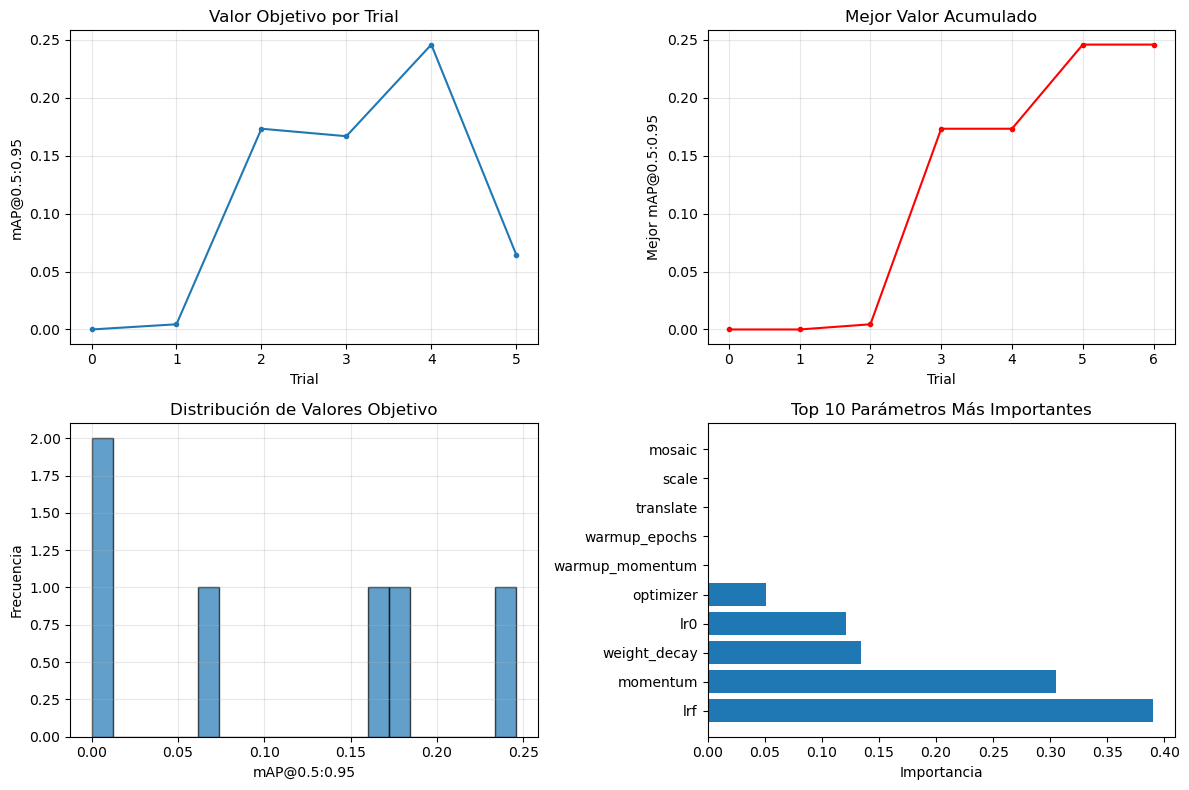

In [6]:
%matplotlib inline
optuna_utils.optuna_optimization_history(study, output_path=image_optuna_path)

In [8]:
with open(f"optuna/optuna_studies/{selected_model}_best_params.json", "r") as f:
    best_params = json.load(f)

print("Mejores hiperparámetros:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Mejores hiperparámetros:
  lr0: 0.00011715937392307068
  lrf: 0.008115595675970505
  momentum: 0.8388169972400026
  weight_decay: 0.0004597505784732166
  optimizer: AdamW
  warmup_epochs: 5
  warmup_momentum: 0.75
  degrees: 45
  translate: 0.1
  scale: 0.06
  flipud: 0.5
  fliplr: 0.5
  mosaic: 0
  close_mosaic: 0


### **K-Fold Cross Validation**

Se concatena train y val para tener un dataset mayor para k-fold 350 imagenes en 5 folds.

In [10]:
metrics_df = kfold_utils.train(model, best_params, model_output_kfold)


Entrenando fold_1 (1/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_1\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.8549542764940538, m

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 658.60it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_1\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 7.32.4 MB/s, size: 107.8 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 388.89it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_1\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_1\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_1
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.15G     0.7957     0.6039     0.8221         80        704: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all         70        881      0.857      0.842      0.912      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.93G     0.7938     0.6095     0.8275         14        704: 100%|██████████| 47/47 [01:30<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

                   all         70        881      0.857      0.843      0.912      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.87G     0.8214     0.6184     0.8271         37        704: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

                   all         70        881       0.85      0.844      0.912      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.91G     0.8133     0.6212      0.827         63        704: 100%|██████████| 47/47 [01:05<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all         70        881      0.853      0.844      0.913      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.98G     0.7961     0.6061     0.8235         51        704: 100%|██████████| 47/47 [00:59<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all         70        881      0.855      0.844      0.913       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.94G     0.8123     0.6108     0.8281         36        704: 100%|██████████| 47/47 [01:31<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all         70        881      0.858      0.843      0.913      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.88G     0.7829      0.615     0.8225         72        704: 100%|██████████| 47/47 [00:48<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

                   all         70        881      0.854      0.848      0.913       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.94G     0.7901     0.5991     0.8269         57        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all         70        881      0.853      0.848      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.97G     0.8377     0.6186     0.8286         64        704: 100%|██████████| 47/47 [01:14<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all         70        881      0.857      0.847      0.913      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.87G     0.8004     0.5991       0.82         55        704: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all         70        881      0.855      0.845      0.914      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.89G     0.7998     0.5934     0.8244         42        704: 100%|██████████| 47/47 [01:23<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all         70        881      0.855      0.847      0.913      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.93G     0.8005     0.6133     0.8301         45        704: 100%|██████████| 47/47 [01:14<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all         70        881      0.856      0.846      0.913      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.93G     0.8184     0.6117     0.8275         45        704: 100%|██████████| 47/47 [01:12<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all         70        881      0.861      0.844      0.913      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       3.9G     0.7877     0.5954     0.8282         86        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

                   all         70        881      0.859      0.846      0.913      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.92G     0.7894     0.6016     0.8242         88        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

                   all         70        881      0.854      0.848      0.913      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.93G     0.7811     0.5993     0.8288         29        704: 100%|██████████| 47/47 [00:58<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

                   all         70        881      0.853      0.849      0.914      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.91G     0.8051     0.6062     0.8242         33        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all         70        881      0.855      0.847      0.914      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       3.9G     0.8034     0.5897     0.8209         47        704: 100%|██████████| 47/47 [00:47<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

                   all         70        881      0.857      0.846      0.914      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.95G     0.7951     0.6044     0.8228         48        704: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all         70        881      0.857      0.844      0.915      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.93G     0.7946     0.6024     0.8275         80        704: 100%|██████████| 47/47 [00:49<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]

                   all         70        881      0.855      0.851      0.915      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.95G     0.7849     0.5971      0.824         24        704: 100%|██████████| 47/47 [01:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all         70        881      0.854      0.846      0.917      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.88G     0.7658     0.5863     0.8222         18        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all         70        881      0.853      0.847      0.915      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.94G     0.7907     0.5883     0.8272         26        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all         70        881      0.856      0.847      0.915      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.96G     0.7838     0.6031     0.8229         87        704: 100%|██████████| 47/47 [01:03<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

                   all         70        881      0.854       0.85      0.915      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.89G      0.782      0.599     0.8227         54        704: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all         70        881      0.851      0.848      0.915      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.96G     0.7966     0.5967     0.8248         38        704: 100%|██████████| 47/47 [00:58<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all         70        881      0.854      0.847      0.915      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.93G     0.7868     0.5917     0.8231         85        704: 100%|██████████| 47/47 [01:08<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all         70        881      0.855      0.848      0.915      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.89G     0.7867     0.6024     0.8262          9        704: 100%|██████████| 47/47 [00:32<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all         70        881      0.848       0.85      0.914      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.93G     0.7966     0.5988     0.8282         36        704: 100%|██████████| 47/47 [01:03<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all         70        881      0.848       0.85      0.913      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.94G     0.7871     0.5863     0.8213         68        704: 100%|██████████| 47/47 [01:04<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all         70        881      0.848      0.848      0.915      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.94G     0.7981     0.6005     0.8283         30        704: 100%|██████████| 47/47 [01:21<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70        881      0.852      0.848      0.914      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.93G     0.8146     0.6037     0.8254         38        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all         70        881       0.86      0.842      0.915      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.95G     0.8003     0.6106      0.824         54        704: 100%|██████████| 47/47 [01:16<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all         70        881      0.845      0.848      0.914      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.97G     0.7852     0.6017     0.8214         13        704: 100%|██████████| 47/47 [01:06<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all         70        881       0.86      0.842      0.915      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.93G     0.7677     0.5876     0.8222         43        704: 100%|██████████| 47/47 [00:52<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all         70        881      0.847       0.85      0.915      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60       3.9G     0.8038     0.6097     0.8302         60        704: 100%|██████████| 47/47 [01:04<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

                   all         70        881      0.861      0.838      0.914      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.88G     0.8353     0.6014     0.8295         39        704: 100%|██████████| 47/47 [00:51<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all         70        881      0.857      0.847      0.915      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.87G     0.7942      0.603     0.8226         85        704: 100%|██████████| 47/47 [00:38<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all         70        881       0.85      0.852      0.918      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.92G     0.7837     0.5973     0.8226         61        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all         70        881      0.857      0.845      0.915      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.98G      0.812     0.5966     0.8258         75        704: 100%|██████████| 47/47 [00:39<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all         70        881      0.846       0.85      0.915      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.94G     0.7832     0.6012     0.8248         72        704: 100%|██████████| 47/47 [01:17<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]

                   all         70        881      0.846      0.851      0.915      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.89G      0.802     0.6043     0.8271         63        704: 100%|██████████| 47/47 [00:47<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all         70        881      0.846      0.851      0.914      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.94G     0.8073     0.5997     0.8276         66        704: 100%|██████████| 47/47 [00:50<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all         70        881      0.845      0.849      0.914      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.94G     0.7868     0.5877     0.8253         25        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all         70        881      0.846      0.849      0.917      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.87G     0.7904     0.6008     0.8267         51        704: 100%|██████████| 47/47 [00:41<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         70        881      0.846      0.854      0.918      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.95G     0.7834     0.5948     0.8215         61        704: 100%|██████████| 47/47 [01:11<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all         70        881       0.86       0.84      0.915      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.88G     0.7826     0.5936     0.8285         77        704: 100%|██████████| 47/47 [01:12<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all         70        881      0.861      0.838      0.915      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.96G     0.7823     0.5912     0.8239         25        704: 100%|██████████| 47/47 [01:01<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all         70        881      0.848      0.849      0.915      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.95G     0.7759     0.5945     0.8277         57        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all         70        881      0.845       0.85      0.914      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.92G     0.7903     0.5941     0.8256         29        704: 100%|██████████| 47/47 [00:38<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

                   all         70        881       0.86      0.839      0.915      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.89G     0.7757     0.5881     0.8235         27        704: 100%|██████████| 47/47 [00:41<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

                   all         70        881      0.848      0.848      0.915      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.93G     0.7745     0.5841     0.8245         64        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

                   all         70        881      0.852      0.847      0.915      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.94G      0.792     0.6012     0.8234         52        704: 100%|██████████| 47/47 [00:37<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all         70        881      0.847      0.852      0.918      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.95G     0.7776     0.5893       0.82         34        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all         70        881      0.845      0.849      0.914      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.93G     0.7963     0.6081     0.8283         55        704: 100%|██████████| 47/47 [01:03<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

                   all         70        881      0.851      0.847      0.915      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.95G     0.7862     0.5921     0.8282         29        704: 100%|██████████| 47/47 [01:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all         70        881      0.844      0.847      0.914      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.89G     0.7887     0.5928     0.8245         24        704: 100%|██████████| 47/47 [00:47<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all         70        881      0.846      0.854      0.918      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.88G      0.797     0.5806     0.8242         32        704: 100%|██████████| 47/47 [01:11<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]

                   all         70        881      0.852      0.847      0.915      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.93G     0.7989     0.6043     0.8248         75        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all         70        881      0.847      0.852      0.915      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.89G     0.7957      0.598     0.8251         45        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

                   all         70        881      0.854      0.848      0.915      0.561



60 epochs completed in 1.118 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_1\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_1\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_1\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


                   all         70        881      0.851      0.852      0.918      0.591
Speed: 0.4ms preprocess, 15.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_1

Entrenando fold_2 (2/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_2\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 677.46it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\train\labels.cache


val: Fast image access  (ping: 0.10.1 ms, read: 6.71.1 MB/s, size: 103.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 361.96it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_2\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.14G     0.7876     0.6034     0.8227         55        704: 100%|██████████| 47/47 [01:08<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

                   all         70       1026      0.826      0.872      0.898      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.96G     0.7633     0.5923      0.827         14        704: 100%|██████████| 47/47 [01:16<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all         70       1026      0.824      0.872      0.897      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.94G     0.7869     0.5929     0.8248         72        704: 100%|██████████| 47/47 [01:22<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all         70       1026      0.826      0.872      0.897      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.89G     0.7819     0.5953     0.8228        115        704: 100%|██████████| 47/47 [01:16<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

                   all         70       1026      0.823      0.876      0.897      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       3.9G     0.7798     0.5922     0.8225         57        704: 100%|██████████| 47/47 [00:59<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all         70       1026      0.819       0.88      0.897      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.91G     0.7797     0.5874     0.8225         19        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all         70       1026      0.818      0.877      0.897      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.96G     0.7785     0.5836     0.8198         43        704: 100%|██████████| 47/47 [00:43<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70       1026      0.819       0.88      0.897      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.94G     0.7927     0.5961     0.8166         36        704: 100%|██████████| 47/47 [01:15<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         70       1026      0.819      0.881      0.897       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.96G     0.8036     0.6006      0.821         32        704: 100%|██████████| 47/47 [01:27<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all         70       1026      0.815       0.88      0.897      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.89G     0.7671     0.5933      0.821         30        704: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]

                   all         70       1026      0.818      0.879      0.897      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.95G      0.783     0.5839     0.8238         53        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all         70       1026      0.815       0.88      0.897      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.94G     0.7853     0.5953     0.8214         36        704: 100%|██████████| 47/47 [01:22<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all         70       1026      0.817      0.881      0.898      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.92G     0.8062     0.6074     0.8291         12        704: 100%|██████████| 47/47 [01:19<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

                   all         70       1026      0.821       0.88      0.897      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       3.9G     0.7757     0.5953     0.8253         61        704: 100%|██████████| 47/47 [01:02<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all         70       1026      0.827      0.878      0.898      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.94G     0.7675     0.5901     0.8301         17        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

                   all         70       1026      0.822      0.878      0.898      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.88G     0.7751     0.5954     0.8253         38        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         70       1026      0.821      0.882      0.898      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.91G     0.7665     0.5777     0.8189         18        704: 100%|██████████| 47/47 [00:56<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70       1026      0.824      0.879      0.898      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       3.9G     0.7801     0.5995     0.8198         40        704: 100%|██████████| 47/47 [00:39<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all         70       1026      0.827      0.872      0.897      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.96G     0.7952     0.6037     0.8233         51        704: 100%|██████████| 47/47 [01:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]

                   all         70       1026       0.83      0.872      0.898       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.96G     0.7836     0.5899     0.8176         30        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all         70       1026      0.826      0.873      0.898      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.95G     0.7633     0.5909     0.8222         90        704: 100%|██████████| 47/47 [01:23<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all         70       1026      0.824      0.873      0.898      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60       3.9G     0.7811     0.5861      0.827         22        704: 100%|██████████| 47/47 [00:38<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all         70       1026      0.821      0.877      0.898      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.95G     0.7872     0.5854     0.8263         36        704: 100%|██████████| 47/47 [01:04<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all         70       1026      0.821      0.877      0.898      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.88G     0.7764     0.5938     0.8179         82        704: 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]

                   all         70       1026      0.823      0.877      0.898      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.88G     0.7813     0.5838     0.8165         24        704: 100%|██████████| 47/47 [00:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]

                   all         70       1026      0.824      0.878      0.898      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.94G     0.7845     0.5846     0.8217         20        704: 100%|██████████| 47/47 [00:42<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all         70       1026      0.823      0.877      0.898      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.93G      0.773     0.5764     0.8184         67        704: 100%|██████████| 47/47 [01:42<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70       1026      0.823      0.878      0.897      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.89G     0.7724     0.5837     0.8233         47        704: 100%|██████████| 47/47 [00:45<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all         70       1026      0.828      0.873      0.897      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.95G     0.7645     0.5883     0.8197         29        704: 100%|██████████| 47/47 [01:14<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

                   all         70       1026      0.829      0.871      0.897      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.01G     0.7848     0.5987     0.8254         65        704: 100%|██████████| 47/47 [01:05<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all         70       1026      0.828      0.873      0.898      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.92G     0.7982     0.5991     0.8224         97        704: 100%|██████████| 47/47 [01:13<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all         70       1026      0.824      0.876      0.897      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.89G     0.7782     0.5959     0.8265         46        704: 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all         70       1026      0.828      0.871      0.897      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60         4G     0.7783     0.5936     0.8182         79        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all         70       1026      0.829      0.871      0.897      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.93G     0.7736     0.5881     0.8176         21        704: 100%|██████████| 47/47 [00:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all         70       1026       0.83      0.867      0.897      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.98G     0.7772     0.5913     0.8229         50        704: 100%|██████████| 47/47 [01:33<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all         70       1026       0.83       0.87      0.897      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      4.01G     0.7663     0.5866     0.8175         49        704: 100%|██████████| 47/47 [00:57<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

                   all         70       1026      0.822       0.88      0.898      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.97G     0.8104     0.6017     0.8235         97        704: 100%|██████████| 47/47 [01:05<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all         70       1026      0.828      0.871      0.898      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.95G     0.7696      0.587      0.819         76        704: 100%|██████████| 47/47 [01:18<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all         70       1026      0.823      0.877      0.898      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.89G     0.8051     0.6043     0.8273        109        704: 100%|██████████| 47/47 [00:43<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all         70       1026       0.83      0.871      0.898      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       3.9G     0.7775     0.5829     0.8164         50        704: 100%|██████████| 47/47 [00:39<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all         70       1026      0.825      0.878      0.898      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.93G     0.7642     0.5836     0.8187         61        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

                   all         70       1026      0.821      0.878      0.898      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.95G     0.7636     0.5852     0.8175         24        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

                   all         70       1026      0.826      0.876      0.898       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.88G     0.7783      0.595     0.8183         61        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

                   all         70       1026      0.828       0.87      0.897      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.93G     0.7601     0.5843     0.8182         49        704: 100%|██████████| 47/47 [01:17<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all         70       1026      0.822      0.879      0.898      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.88G     0.7742     0.5876     0.8224         22        704: 100%|██████████| 47/47 [00:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all         70       1026       0.82      0.878      0.897      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.93G     0.7537     0.5874     0.8163         31        704: 100%|██████████| 47/47 [01:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all         70       1026      0.824      0.879      0.898      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60         4G     0.7788     0.5908     0.8189         49        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

                   all         70       1026       0.83      0.871      0.898      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.89G      0.757     0.5847     0.8172         23        704: 100%|██████████| 47/47 [00:51<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all         70       1026      0.821      0.877      0.898      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.94G      0.768      0.593     0.8165         45        704: 100%|██████████| 47/47 [01:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all         70       1026      0.823      0.876      0.898      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.88G     0.7882     0.6016      0.822         17        704: 100%|██████████| 47/47 [00:49<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all         70       1026      0.825      0.878      0.898      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.96G     0.7766     0.5899     0.8228         47        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all         70       1026      0.824      0.874      0.898      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.95G     0.7635     0.5849     0.8219         86        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

                   all         70       1026      0.821      0.876      0.898       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.96G     0.7656      0.581     0.8168         29        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all         70       1026      0.822      0.875      0.898       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.94G      0.777     0.5874     0.8222         33        704: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all         70       1026      0.821      0.876      0.898      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.97G     0.7705     0.5872     0.8206         81        704: 100%|██████████| 47/47 [01:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

                   all         70       1026      0.823      0.875      0.898      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.95G     0.8042     0.5867     0.8289         83        704: 100%|██████████| 47/47 [01:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]

                   all         70       1026      0.825      0.878      0.898      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.91G     0.7949     0.5889     0.8254         85        704: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all         70       1026      0.821      0.875      0.898      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.89G     0.7835     0.5883     0.8212         70        704: 100%|██████████| 47/47 [00:58<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all         70       1026       0.82      0.877      0.898      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.92G     0.7738     0.5957     0.8235         81        704: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all         70       1026      0.822      0.876      0.898      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.96G     0.7685     0.5771     0.8174         36        704: 100%|██████████| 47/47 [01:05<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70       1026      0.825      0.875      0.898      0.567



60 epochs completed in 1.139 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_2\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_2\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_2\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


                   all         70       1026      0.823      0.877      0.898      0.606
Speed: 0.6ms preprocess, 15.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_2

Entrenando fold_3 (3/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_3\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 635.36it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 7.02.4 MB/s, size: 117.2 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 401.82it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_3\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.05G     0.7844     0.5952     0.8208         44        704: 100%|██████████| 47/47 [01:46<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

                   all         70        874      0.871      0.869      0.929      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.94G     0.7612     0.5791      0.825         34        704: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

                   all         70        874      0.871      0.869      0.929      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.95G     0.7667     0.6001     0.8184         53        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]

                   all         70        874      0.859      0.887       0.93      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.99G      0.779     0.5949     0.8195         85        704: 100%|██████████| 47/47 [01:16<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

                   all         70        874      0.871      0.868       0.93      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.89G     0.7997     0.5943     0.8234         62        704: 100%|██████████| 47/47 [01:20<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all         70        874      0.861      0.883      0.928      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.91G     0.7828     0.5942     0.8238         20        704: 100%|██████████| 47/47 [01:27<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all         70        874      0.862      0.879       0.93       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.98G     0.7704     0.5889     0.8206         68        704: 100%|██████████| 47/47 [01:28<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all         70        874      0.862      0.879       0.93      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.95G     0.7767     0.5941     0.8172         73        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all         70        874      0.861      0.883      0.929      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.96G     0.7864     0.5938     0.8244         28        704: 100%|██████████| 47/47 [01:52<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all         70        874      0.861      0.883      0.929      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.95G     0.8023     0.6032     0.8243         69        704: 100%|██████████| 47/47 [01:17<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all         70        874      0.847      0.892       0.93      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.92G     0.7722     0.5955     0.8191         58        704: 100%|██████████| 47/47 [01:21<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all         70        874      0.851      0.894      0.931      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.94G     0.7747      0.589     0.8236         36        704: 100%|██████████| 47/47 [01:03<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all         70        874      0.868      0.868      0.931      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.95G     0.7735     0.5992      0.829         28        704: 100%|██████████| 47/47 [00:59<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all         70        874       0.85      0.893       0.93        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.88G     0.7691       0.58     0.8209         72        704: 100%|██████████| 47/47 [01:11<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70        874      0.876      0.858      0.929      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.94G     0.7496     0.5731     0.8145        109        704: 100%|██████████| 47/47 [01:14<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  2.00it/s]

                   all         70        874      0.872      0.865      0.929      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.88G     0.7783     0.5795      0.822         22        704: 100%|██████████| 47/47 [01:42<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all         70        874      0.848      0.894      0.932      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.91G     0.7783     0.5868     0.8216         16        704: 100%|██████████| 47/47 [01:19<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all         70        874      0.874      0.861      0.929      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.98G     0.7711     0.5941     0.8164         42        704: 100%|██████████| 47/47 [01:25<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]

                   all         70        874      0.861       0.88       0.93      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.95G     0.7744     0.5926     0.8262         78        704: 100%|██████████| 47/47 [01:27<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all         70        874      0.873      0.864       0.93      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60         4G     0.7708     0.5751     0.8222         31        704: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all         70        874       0.87      0.868      0.929      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.95G     0.7526      0.572     0.8185         28        704: 100%|██████████| 47/47 [01:17<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all         70        874      0.872      0.865       0.93      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.91G     0.7809     0.5968     0.8213         47        704: 100%|██████████| 47/47 [00:45<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all         70        874      0.871      0.865      0.929      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.93G     0.7695      0.584     0.8235          9        704: 100%|██████████| 47/47 [01:05<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

                   all         70        874      0.873       0.87      0.929      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.94G     0.7482     0.5879     0.8174         24        704: 100%|██████████| 47/47 [01:36<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

                   all         70        874      0.873       0.86       0.93       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.88G     0.7947     0.5914     0.8241         68        704: 100%|██████████| 47/47 [00:57<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all         70        874       0.86      0.887      0.932      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.95G     0.7763     0.5946     0.8242         14        704: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all         70        874      0.864      0.881      0.932      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.94G     0.7868     0.6033     0.8238        109        704: 100%|██████████| 47/47 [01:25<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70        874      0.876      0.858      0.929      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.88G     0.7878     0.5965     0.8234         39        704: 100%|██████████| 47/47 [01:46<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all         70        874      0.854       0.89       0.93      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.96G     0.7732     0.5863     0.8185         46        704: 100%|██████████| 47/47 [01:47<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all         70        874      0.863      0.879       0.93      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.96G     0.7857     0.5993     0.8254         70        704: 100%|██████████| 47/47 [01:56<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70        874      0.862      0.879       0.93      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.94G     0.7884     0.5938     0.8263         40        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all         70        874      0.875       0.86       0.93      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.94G      0.784     0.5947     0.8244         47        704: 100%|██████████| 47/47 [01:23<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

                   all         70        874      0.863       0.88       0.93       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.97G     0.8004     0.5919      0.823         50        704: 100%|██████████| 47/47 [01:22<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all         70        874      0.876      0.861       0.93      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.96G     0.7776       0.59      0.824         32        704: 100%|██████████| 47/47 [01:12<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

                   all         70        874      0.848      0.895      0.931      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.94G     0.7731     0.5886     0.8227        110        704: 100%|██████████| 47/47 [01:18<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all         70        874      0.876      0.858       0.93       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.95G     0.7778     0.5804     0.8238         32        704: 100%|██████████| 47/47 [00:58<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]

                   all         70        874      0.848      0.894      0.931      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.96G      0.801      0.596     0.8232         30        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all         70        874      0.877      0.858       0.93      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.94G     0.7608     0.5828     0.8238         86        704: 100%|██████████| 47/47 [01:23<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all         70        874       0.87      0.865       0.93      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.91G     0.7871     0.6087     0.8187         15        704: 100%|██████████| 47/47 [01:01<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all         70        874       0.87      0.871       0.93      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       3.9G     0.8003     0.5895     0.8251         78        704: 100%|██████████| 47/47 [00:56<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]

                   all         70        874      0.845      0.894      0.932      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.93G     0.7745     0.5913     0.8219         90        704: 100%|██████████| 47/47 [01:21<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]

                   all         70        874      0.875      0.864      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60       3.9G      0.782     0.5891     0.8183         53        704: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all         70        874      0.845      0.894      0.931      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.94G     0.7715     0.5929     0.8172         14        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

                   all         70        874      0.874      0.866       0.93      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.88G     0.7732     0.5895     0.8241         20        704: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all         70        874      0.874      0.864      0.931      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.88G     0.7658     0.5867     0.8195         71        704: 100%|██████████| 47/47 [00:51<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all         70        874      0.874      0.866       0.93      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.88G     0.7448     0.5753      0.819         56        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all         70        874      0.863       0.88       0.93       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.88G     0.7653     0.5837     0.8222         86        704: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all         70        874      0.866       0.88       0.93      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.93G     0.7639     0.5888     0.8233         34        704: 100%|██████████| 47/47 [01:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all         70        874      0.875      0.867       0.93       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.87G       0.76     0.5817     0.8203         66        704: 100%|██████████| 47/47 [00:48<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all         70        874      0.846      0.894      0.931      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.87G     0.7757     0.5977     0.8246         72        704: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

                   all         70        874      0.864      0.884       0.93      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60         4G     0.7657     0.5833     0.8171         42        704: 100%|██████████| 47/47 [01:35<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all         70        874      0.867      0.873       0.93      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.91G     0.7581     0.5819     0.8209         58        704: 100%|██████████| 47/47 [00:55<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

                   all         70        874      0.875      0.864       0.93      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.94G     0.7764     0.5878     0.8246         11        704: 100%|██████████| 47/47 [01:38<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all         70        874      0.872      0.867       0.93      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.93G     0.7652     0.5883     0.8196         30        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

                   all         70        874      0.874      0.863       0.93      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.93G       0.78     0.5903     0.8285         35        704: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70        874      0.844      0.894      0.932      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.94G     0.7812      0.587     0.8274         49        704: 100%|██████████| 47/47 [01:09<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all         70        874      0.848      0.894       0.93       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.93G      0.779     0.5922     0.8209         40        704: 100%|██████████| 47/47 [01:13<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all         70        874      0.872      0.865       0.93      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.88G     0.7727     0.5853     0.8194         61        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

                   all         70        874      0.867      0.869      0.931      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.94G     0.7932      0.595      0.823         52        704: 100%|██████████| 47/47 [01:26<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

                   all         70        874      0.871      0.867       0.93      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.97G     0.7602     0.5787     0.8158         61        704: 100%|██████████| 47/47 [01:08<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all         70        874      0.864      0.881      0.931      0.605



60 epochs completed in 1.336 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_3\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_3\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_3\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


                   all         70        874      0.864      0.879       0.93      0.632
Speed: 0.6ms preprocess, 15.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_3

Entrenando fold_4 (4/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_4\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 660.99it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\train\labels.cache


val: Fast image access  (ping: 0.20.2 ms, read: 7.52.7 MB/s, size: 93.8 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 398.29it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_4\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_4
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.16G     0.7822     0.5827     0.8265         41        704: 100%|██████████| 47/47 [01:42<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all         70       1005      0.848      0.831      0.897      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.94G     0.7916     0.5802     0.8241         52        704: 100%|██████████| 47/47 [01:32<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all         70       1005      0.847      0.832      0.896      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.93G     0.7707     0.5819     0.8209         41        704: 100%|██████████| 47/47 [01:12<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all         70       1005      0.847      0.832      0.896      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.88G     0.7812     0.5736     0.8191         33        704: 100%|██████████| 47/47 [00:49<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]

                   all         70       1005      0.849       0.83      0.896      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60         4G      0.781     0.5771     0.8252         69        704: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all         70       1005      0.848      0.831      0.897      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.92G     0.7886     0.5952     0.8266         32        704: 100%|██████████| 47/47 [01:48<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all         70       1005       0.85      0.828      0.896      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.94G     0.7577     0.5662     0.8197         51        704: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all         70       1005      0.851      0.827      0.895      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.94G     0.7868     0.5803     0.8227         86        704: 100%|██████████| 47/47 [01:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]

                   all         70       1005      0.852      0.827      0.896      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.94G     0.8006     0.5901     0.8281         33        704: 100%|██████████| 47/47 [01:22<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all         70       1005      0.855      0.827      0.896      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.93G     0.7895     0.5866     0.8254         40        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all         70       1005      0.852      0.828      0.896      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.93G     0.7944      0.585     0.8255         60        704: 100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all         70       1005      0.851      0.828      0.896      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.95G     0.7811     0.5852     0.8226         50        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all         70       1005      0.848      0.828      0.896      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.94G     0.7909     0.5876     0.8219         36        704: 100%|██████████| 47/47 [01:19<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all         70       1005      0.851      0.825      0.897      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.92G     0.7835     0.5756     0.8213         27        704: 100%|██████████| 47/47 [00:55<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all         70       1005      0.849      0.828      0.895      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.94G     0.7749     0.5769     0.8224        108        704: 100%|██████████| 47/47 [01:03<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all         70       1005      0.849      0.823      0.895      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.94G     0.7591     0.5747     0.8192         17        704: 100%|██████████| 47/47 [01:02<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all         70       1005       0.85      0.829      0.897      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.95G      0.756     0.5722     0.8219         19        704: 100%|██████████| 47/47 [01:00<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all         70       1005       0.85      0.827      0.896      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.95G     0.7867     0.5775     0.8265         25        704: 100%|██████████| 47/47 [01:09<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all         70       1005       0.85      0.827      0.895      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.95G     0.7498     0.5797     0.8165         47        704: 100%|██████████| 47/47 [00:52<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all         70       1005      0.849      0.828      0.897       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.88G     0.7766     0.5904     0.8232         17        704: 100%|██████████| 47/47 [00:39<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         70       1005      0.842      0.834      0.896      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.94G     0.7752     0.5738     0.8215         13        704: 100%|██████████| 47/47 [01:09<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all         70       1005      0.849      0.826      0.897      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.96G     0.7937     0.5835     0.8221         25        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all         70       1005      0.849      0.828      0.897      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.95G     0.7807     0.5943     0.8226         16        704: 100%|██████████| 47/47 [00:51<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all         70       1005      0.848      0.829      0.896      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.94G     0.7653     0.5733      0.821         96        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all         70       1005      0.846       0.83      0.896      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.94G     0.7845     0.5856     0.8167         34        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all         70       1005      0.847      0.831      0.897      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.88G     0.7883     0.5882     0.8239         24        704: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]

                   all         70       1005      0.845      0.835      0.896      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.93G     0.7834     0.5878     0.8202        113        704: 100%|██████████| 47/47 [01:02<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

                   all         70       1005       0.85      0.828      0.896      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.87G     0.7802     0.5874     0.8171         32        704: 100%|██████████| 47/47 [00:31<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all         70       1005      0.846       0.83      0.897      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.94G     0.7619     0.5799     0.8184         23        704: 100%|██████████| 47/47 [01:33<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all         70       1005      0.843      0.836      0.897      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60         4G     0.7804     0.5776     0.8217         95        704: 100%|██████████| 47/47 [00:46<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]

                   all         70       1005      0.846      0.832      0.897      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.94G     0.7867     0.5889     0.8244         49        704: 100%|██████████| 47/47 [01:45<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all         70       1005      0.841      0.836      0.896      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.94G     0.7936     0.5757      0.826         48        704: 100%|██████████| 47/47 [01:03<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all         70       1005      0.843      0.834      0.895      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.95G      0.776     0.5804     0.8229         49        704: 100%|██████████| 47/47 [00:59<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all         70       1005      0.844      0.831      0.897      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.97G      0.781     0.5848      0.823         15        704: 100%|██████████| 47/47 [01:03<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all         70       1005      0.842      0.837      0.897      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.99G     0.7732     0.5754     0.8181         35        704: 100%|██████████| 47/47 [01:09<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70       1005      0.842      0.835      0.896      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.89G     0.7829      0.579     0.8208         44        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all         70       1005      0.844      0.834      0.897      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.93G     0.8101     0.6055      0.828         25        704: 100%|██████████| 47/47 [00:53<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]

                   all         70       1005      0.843      0.835      0.897      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.93G     0.7858     0.5865      0.823         52        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all         70       1005      0.842      0.834      0.896      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.93G      0.811      0.591      0.828         57        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all         70       1005      0.845      0.829      0.896      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.95G     0.7957     0.5834     0.8197         50        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all         70       1005      0.846      0.832      0.897      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.93G     0.7998     0.5826     0.8299        119        704: 100%|██████████| 47/47 [00:42<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all         70       1005      0.845       0.83      0.896      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.94G     0.7948     0.5788     0.8253         58        704: 100%|██████████| 47/47 [00:57<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all         70       1005      0.846       0.83      0.896      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.88G     0.7899     0.5948     0.8212         17        704: 100%|██████████| 47/47 [00:43<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all         70       1005      0.847      0.831      0.897      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.95G      0.773     0.5748     0.8196         19        704: 100%|██████████| 47/47 [01:44<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all         70       1005      0.847      0.831      0.896      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.94G     0.7902     0.5734     0.8285         80        704: 100%|██████████| 47/47 [00:58<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70       1005      0.847      0.829      0.895      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       3.9G     0.7847     0.5817     0.8239         40        704: 100%|██████████| 47/47 [01:25<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

                   all         70       1005      0.845      0.833      0.895      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.87G     0.7791     0.5718     0.8191         40        704: 100%|██████████| 47/47 [01:08<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all         70       1005      0.845      0.833      0.895      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.94G     0.7543     0.5715      0.819         32        704: 100%|██████████| 47/47 [01:09<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

                   all         70       1005      0.846      0.829      0.896      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.87G     0.7722     0.5805      0.819         27        704: 100%|██████████| 47/47 [01:21<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all         70       1005      0.847       0.83      0.896      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.93G     0.7797     0.5886     0.8203         22        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all         70       1005      0.846       0.83      0.895      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.94G     0.7769      0.572     0.8243         68        704: 100%|██████████| 47/47 [01:30<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]

                   all         70       1005      0.847       0.83      0.896      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.88G     0.7707     0.5799     0.8263         39        704: 100%|██████████| 47/47 [00:53<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all         70       1005      0.846       0.83      0.895      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.94G     0.7512     0.5778     0.8181         21        704: 100%|██████████| 47/47 [00:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all         70       1005      0.846      0.828      0.896      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.88G     0.7724     0.5746     0.8225         30        704: 100%|██████████| 47/47 [01:15<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

                   all         70       1005      0.845       0.83      0.896      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.93G     0.7668     0.5762     0.8203         60        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

                   all         70       1005      0.845      0.829      0.896       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.94G     0.7975     0.5883     0.8265         22        704: 100%|██████████| 47/47 [01:09<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all         70       1005      0.845      0.828      0.896      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.88G      0.785     0.5763     0.8223         65        704: 100%|██████████| 47/47 [01:17<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all         70       1005      0.844      0.829      0.896      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.89G     0.7946     0.5738     0.8255         59        704: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70       1005      0.846      0.828      0.896      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.95G     0.7731     0.5788     0.8199         30        704: 100%|██████████| 47/47 [01:25<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all         70       1005      0.846      0.831      0.895      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.91G     0.7781     0.5866     0.8216         30        704: 100%|██████████| 47/47 [00:36<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

                   all         70       1005      0.845      0.829      0.895      0.567



60 epochs completed in 1.228 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_4\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_4\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_4\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


                   all         70       1005      0.842      0.834      0.896      0.608
Speed: 0.6ms preprocess, 24.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_4

Entrenando fold_5 (5/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_5\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_5\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 607.66it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_5\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 7.31.3 MB/s, size: 109.2 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_5\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 369.16it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_5\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_5\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_5
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.06G     0.7959     0.5916     0.8266         42        704: 100%|██████████| 47/47 [01:30<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

                   all         70       1026      0.839      0.866      0.914      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.95G     0.7954     0.5912     0.8283         47        704: 100%|██████████| 47/47 [01:14<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

                   all         70       1026      0.837      0.865      0.913      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.89G     0.7831      0.592     0.8236        125        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

                   all         70       1026      0.842      0.864      0.913      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.96G     0.8071     0.6024     0.8265        105        704: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70       1026      0.838      0.864      0.913      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.88G     0.7959     0.5939     0.8279         38        704: 100%|██████████| 47/47 [00:59<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all         70       1026      0.843      0.861      0.913      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.96G     0.7817     0.5877     0.8232         80        704: 100%|██████████| 47/47 [01:01<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all         70       1026       0.84      0.862      0.913      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.91G     0.7771     0.5882     0.8245         46        704: 100%|██████████| 47/47 [00:49<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all         70       1026      0.845      0.858      0.913      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.95G     0.8096     0.5955      0.824         34        704: 100%|██████████| 47/47 [00:45<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all         70       1026      0.847      0.859      0.913      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.94G     0.8069      0.597     0.8282         36        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all         70       1026      0.847      0.856      0.913      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.88G     0.8029     0.5879     0.8299         27        704: 100%|██████████| 47/47 [00:41<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all         70       1026      0.851      0.855      0.913      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.93G     0.7906      0.576     0.8223         44        704: 100%|██████████| 47/47 [00:51<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all         70       1026      0.848      0.856      0.913      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.88G     0.8067     0.6079      0.832         67        704: 100%|██████████| 47/47 [01:28<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all         70       1026      0.839      0.862      0.913      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.95G     0.8084     0.5956     0.8265         49        704: 100%|██████████| 47/47 [01:17<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all         70       1026      0.848      0.856      0.913      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       3.9G     0.7825     0.5875     0.8271         87        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all         70       1026      0.846      0.858      0.913      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.95G     0.7986      0.589     0.8271         38        704: 100%|██████████| 47/47 [00:56<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

                   all         70       1026      0.844      0.861      0.913      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.94G     0.7773     0.5891     0.8231         49        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all         70       1026      0.848      0.858      0.913      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.89G     0.7736     0.5956      0.819         53        704: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all         70       1026      0.843      0.859      0.913      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.91G     0.7896     0.5831     0.8265         78        704: 100%|██████████| 47/47 [01:15<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all         70       1026      0.843       0.86      0.913      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.87G     0.7905     0.5902     0.8221         50        704: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all         70       1026      0.848      0.859      0.913      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.95G     0.7937     0.5855     0.8217         56        704: 100%|██████████| 47/47 [01:17<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]

                   all         70       1026      0.847      0.859      0.913      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.94G     0.7786     0.5829     0.8223         30        704: 100%|██████████| 47/47 [01:26<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all         70       1026      0.844      0.862      0.913      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.93G     0.8047      0.595     0.8238         88        704: 100%|██████████| 47/47 [01:04<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all         70       1026      0.837      0.865      0.913      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.97G     0.7911      0.592     0.8254         16        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]

                   all         70       1026      0.837      0.863      0.913      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.93G     0.7844     0.5843      0.825         46        704: 100%|██████████| 47/47 [01:18<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

                   all         70       1026      0.841      0.861      0.913      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.92G     0.8057     0.5968     0.8199         77        704: 100%|██████████| 47/47 [01:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all         70       1026      0.842      0.862      0.913      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.95G     0.8214     0.5952     0.8315        109        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]

                   all         70       1026       0.84      0.864      0.913      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.87G     0.7962        0.6     0.8268         70        704: 100%|██████████| 47/47 [02:05<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all         70       1026      0.841      0.862      0.912      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.93G     0.7835     0.5953     0.8207         31        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

                   all         70       1026      0.843      0.861      0.913      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.89G     0.7598     0.5785      0.824         16        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

                   all         70       1026      0.845      0.859      0.913      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.93G     0.7866     0.5871     0.8252         54        704: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all         70       1026      0.842       0.86      0.913      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.99G     0.7793     0.5904     0.8305         67        704: 100%|██████████| 47/47 [01:13<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all         70       1026      0.844       0.86      0.913      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.87G     0.7915     0.5952     0.8272         23        704: 100%|██████████| 47/47 [01:53<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all         70       1026      0.844      0.863      0.913      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.96G     0.7919     0.5987     0.8257         91        704: 100%|██████████| 47/47 [00:47<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all         70       1026      0.843      0.865      0.913      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.88G     0.7843     0.5914     0.8222         30        704: 100%|██████████| 47/47 [00:38<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all         70       1026      0.845      0.863      0.913      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.97G     0.7818     0.6038     0.8237         41        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

                   all         70       1026      0.844      0.862      0.913      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.89G     0.8128     0.5958     0.8289         32        704: 100%|██████████| 47/47 [00:59<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70       1026      0.843      0.862      0.913      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.88G     0.8271     0.5967     0.8305         61        704: 100%|██████████| 47/47 [01:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all         70       1026      0.846      0.861      0.913      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.87G     0.7823     0.5887     0.8213         63        704: 100%|██████████| 47/47 [01:30<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all         70       1026      0.841      0.863      0.913      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.92G     0.7913     0.5883     0.8283         64        704: 100%|██████████| 47/47 [01:18<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all         70       1026      0.844      0.865      0.913      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.89G     0.7824     0.5903     0.8241         49        704: 100%|██████████| 47/47 [00:40<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

                   all         70       1026      0.843      0.863      0.913      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.93G     0.7767     0.5804     0.8282         78        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all         70       1026      0.846      0.859      0.913      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.94G     0.8003     0.5786      0.825         34        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all         70       1026      0.843      0.863      0.913      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.95G     0.7885     0.5892     0.8246         32        704: 100%|██████████| 47/47 [01:24<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70       1026      0.845      0.866      0.913      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60       3.9G     0.7764     0.5842     0.8218         11        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

                   all         70       1026      0.844      0.863      0.913      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.98G     0.7985     0.6008     0.8274         31        704: 100%|██████████| 47/47 [01:19<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]

                   all         70       1026      0.844      0.859      0.913      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.94G     0.7756     0.5849     0.8221         31        704: 100%|██████████| 47/47 [01:19<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all         70       1026      0.845      0.859      0.913      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.89G     0.8225     0.6051     0.8244         38        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all         70       1026      0.844      0.862      0.912      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.96G     0.7866     0.5813     0.8287         42        704: 100%|██████████| 47/47 [00:58<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70       1026      0.841      0.865      0.913      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.94G     0.7891     0.5902     0.8255         32        704: 100%|██████████| 47/47 [01:03<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]

                   all         70       1026      0.839      0.867      0.913      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.87G     0.7693     0.5857     0.8191         21        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

                   all         70       1026      0.842      0.861      0.912      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.95G     0.7722     0.5794     0.8238         35        704: 100%|██████████| 47/47 [01:12<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all         70       1026      0.843      0.861      0.912       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.94G     0.7872     0.5909     0.8256         63        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all         70       1026      0.842      0.861      0.913      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.96G     0.7814     0.5809     0.8202         13        704: 100%|██████████| 47/47 [00:51<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all         70       1026      0.844      0.857      0.913      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.88G     0.7762     0.5803     0.8158         56        704: 100%|██████████| 47/47 [01:38<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all         70       1026      0.846      0.859      0.913      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.93G     0.7922     0.5988     0.8283         15        704: 100%|██████████| 47/47 [01:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]

                   all         70       1026      0.843      0.863      0.913      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.88G     0.7868     0.5937     0.8258         89        704: 100%|██████████| 47/47 [00:53<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all         70       1026      0.845      0.858      0.913      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.97G     0.8295     0.5925       0.83         55        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all         70       1026      0.844      0.859      0.913      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.98G     0.8139     0.5982     0.8297         25        704: 100%|██████████| 47/47 [01:00<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all         70       1026      0.843       0.86      0.913      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.93G     0.7831     0.6018     0.8206         78        704: 100%|██████████| 47/47 [01:05<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all         70       1026      0.844      0.859      0.913      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.89G     0.7953     0.5895     0.8225         11        704: 100%|██████████| 47/47 [00:41<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all         70       1026      0.843      0.861      0.913      0.591



60 epochs completed in 1.231 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_5\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_5\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_5\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


                   all         70       1026      0.841      0.863      0.913      0.632
Speed: 0.5ms preprocess, 15.4ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_5


In [11]:
kfold_utils.save_results(metrics_df, model_output_kfold)


Resultados por fold:
   fold  mAP50-95    mAP50  precision   recall
0     1   0.59153  0.91763    0.84953  0.85244
1     2   0.60544  0.89805    0.82332  0.87657
2     3   0.63170  0.93020    0.86295  0.87893
3     4   0.60728  0.89573    0.84216  0.83383
4     5   0.63206  0.91316    0.84029  0.86160

Promedio de métricas:
fold         3.000000
mAP50-95     0.613602
mAP50        0.910954
precision    0.843650
recall       0.860674
dtype: float64

Directorios temporales eliminados.


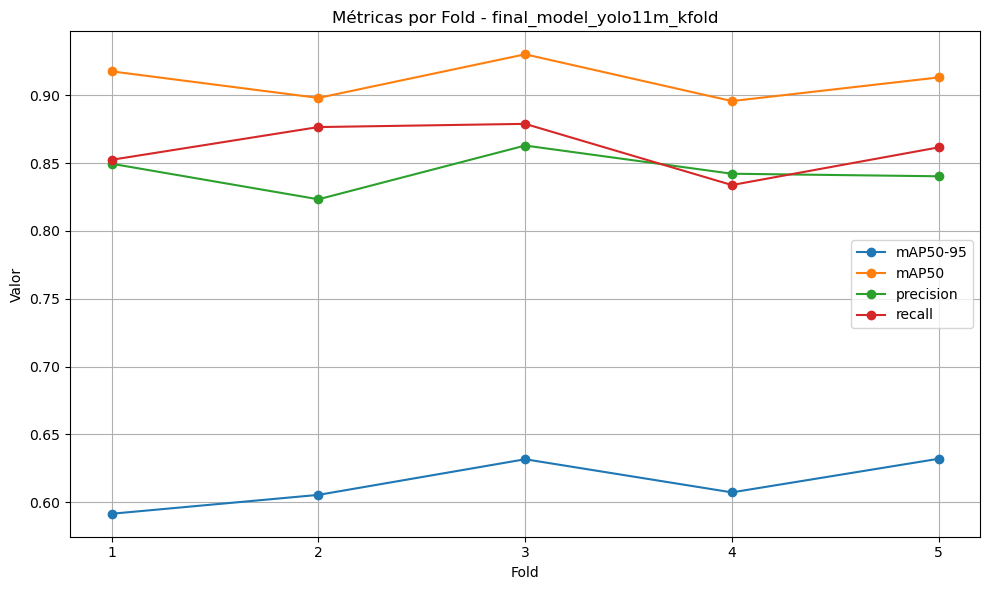

In [12]:
kfold_utils.plot_kfold_metrics(metrics_df, model_output_kfold)

### **Train**

In [6]:
params = getattr(config, name_best_params)

model.train(
    data="cells.yaml",
    epochs=config.EPOCH_TRAIN,   
    imgsz=config.IMGSZ,          
    batch=config.BATCH,           
    name=model_output,
    save=True,         
    **params
)

New https://pypi.org/project/ultralytics/8.3.176 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005611516415334506, lrf=0.00892718030435363, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolov10s.pt, momentum=0.9097990912717108, mosaic=0, mult

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 129.226.9 MB/s, size: 103.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\final_model_yolov10s\labels.jpg... 
optimizer: SGD(lr=0.0005611516415334506, momentum=0.9097990912717108) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00037207437472915983), 111 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov10s
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.73G      5.347      20.61      2.809        139        704: 100%|██████████| 28/28 [00:58<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all         70        846    0.00794    0.00591   0.000691    0.00029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.79G      4.824      9.634      2.505        130        704: 100%|██████████| 28/28 [00:48<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all         70        846      0.274      0.215      0.151     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.77G      4.009      5.056      2.244        186        704: 100%|██████████| 28/28 [00:34<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all         70        846       0.43      0.454      0.408      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.89G      3.565      3.678      2.099        140        704: 100%|██████████| 28/28 [00:55<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all         70        846      0.472      0.561      0.471      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.83G       3.26          3      2.022        187        704: 100%|██████████| 28/28 [00:34<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all         70        846      0.521      0.631      0.537      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.75G      3.023      2.615      1.952         88        704: 100%|██████████| 28/28 [00:31<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all         70        846      0.624      0.695       0.66      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.88G      2.785      2.352      1.895        137        704: 100%|██████████| 28/28 [00:49<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all         70        846       0.57      0.716      0.638      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.81G      2.704       2.31      1.873        124        704: 100%|██████████| 28/28 [00:46<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all         70        846      0.665      0.699      0.719      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.76G      2.691      2.207      1.856         71        704: 100%|██████████| 28/28 [00:21<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]

                   all         70        846      0.741      0.701      0.782       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.87G      2.596      2.101       1.82         67        704: 100%|██████████| 28/28 [00:36<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all         70        846      0.724       0.74      0.792      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.78G      2.442      2.044      1.808         77        704: 100%|██████████| 28/28 [00:43<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all         70        846      0.747      0.735      0.805      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.83G      2.393      1.916      1.787        104        704: 100%|██████████| 28/28 [00:57<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all         70        846      0.745      0.774      0.826      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40       3.8G      2.347      1.851      1.778        102        704: 100%|██████████| 28/28 [00:32<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all         70        846      0.772       0.77      0.838      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.79G      2.248      1.712      1.754        149        704: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

                   all         70        846      0.773      0.798       0.85      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.86G      2.185      1.637      1.747        161        704: 100%|██████████| 28/28 [00:50<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]

                   all         70        846      0.766      0.781      0.846        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.77G      2.149      1.616      1.746        132        704: 100%|██████████| 28/28 [00:40<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all         70        846      0.784      0.797      0.858      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.81G      2.097      1.531      1.728        201        704: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all         70        846      0.799      0.807      0.865      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.84G      2.105      1.529      1.733        155        704: 100%|██████████| 28/28 [00:38<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

                   all         70        846       0.77      0.798      0.841      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.79G      2.114       1.53      1.727        203        704: 100%|██████████| 28/28 [00:49<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all         70        846      0.777      0.817      0.858      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.78G      2.042      1.466       1.72         85        704: 100%|██████████| 28/28 [00:43<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]

                   all         70        846      0.814       0.81      0.876      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40       3.8G       2.07       1.47      1.715        171        704: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all         70        846      0.812      0.817      0.871      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40       3.9G      2.027      1.458      1.717        156        704: 100%|██████████| 28/28 [00:51<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all         70        846      0.814       0.81      0.868      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40       3.8G      2.028      1.476      1.712         52        704: 100%|██████████| 28/28 [00:39<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all         70        846      0.803      0.836       0.88       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.77G      2.026      1.471      1.719        167        704: 100%|██████████| 28/28 [00:47<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

                   all         70        846      0.796      0.839      0.877      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.78G      2.006      1.452      1.706        250        704: 100%|██████████| 28/28 [00:29<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all         70        846      0.818      0.837      0.885      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40       3.8G      1.955      1.426      1.711         79        704: 100%|██████████| 28/28 [00:37<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all         70        846      0.801      0.826      0.872      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.78G      1.927       1.41      1.704        233        704: 100%|██████████| 28/28 [00:53<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all         70        846      0.799      0.863      0.886      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.81G      1.919      1.371      1.704        126        704: 100%|██████████| 28/28 [00:51<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all         70        846        0.8      0.863      0.887       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.88G      1.922      1.381      1.696        144        704: 100%|██████████| 28/28 [00:41<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all         70        846      0.806      0.867       0.89      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40       3.8G      1.907      1.366      1.693        193        704: 100%|██████████| 28/28 [00:31<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all         70        846      0.819      0.835      0.887      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.83G       1.89      1.364      1.692        116        704: 100%|██████████| 28/28 [00:34<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all         70        846      0.808      0.833      0.882      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.86G      1.955      1.378      1.711        133        704: 100%|██████████| 28/28 [00:34<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

                   all         70        846      0.815      0.829      0.887      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.83G      1.922      1.331       1.69        155        704: 100%|██████████| 28/28 [00:38<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all         70        846      0.795      0.859      0.889      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.84G      1.882      1.355      1.685        155        704: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all         70        846      0.794      0.866      0.891       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.89G      1.856      1.367      1.691        131        704: 100%|██████████| 28/28 [00:27<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all         70        846      0.807      0.858      0.891      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.77G      1.881      1.359      1.694         81        704: 100%|██████████| 28/28 [00:41<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all         70        846      0.825      0.834       0.89      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.85G      1.889      1.327      1.685         97        704: 100%|██████████| 28/28 [00:37<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all         70        846      0.827      0.831       0.89      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.75G      1.881      1.367      1.692        128        704: 100%|██████████| 28/28 [00:38<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

                   all         70        846      0.833       0.82      0.891      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.86G      1.883      1.335      1.692         89        704: 100%|██████████| 28/28 [00:28<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all         70        846      0.827      0.827      0.891       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.84G      1.884      1.339      1.687        105        704: 100%|██████████| 28/28 [00:34<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all         70        846      0.829      0.825       0.89      0.634



40 epochs completed in 0.464 hours.
Optimizer stripped from runs\detect\final_model_yolov10s\weights\last.pt, 16.5MB
Optimizer stripped from runs\detect\final_model_yolov10s\weights\best.pt, 16.5MB

Validating runs\detect\final_model_yolov10s\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


                   all         70        846      0.829      0.828       0.89      0.633
Speed: 0.5ms preprocess, 8.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\final_model_yolov10s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000019814A85110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### **Train Plots**

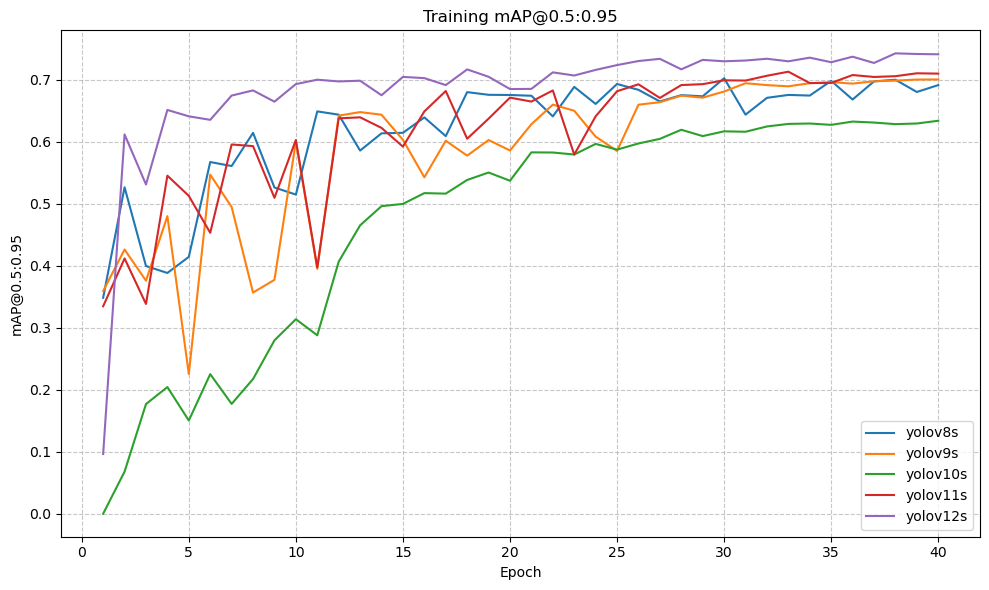

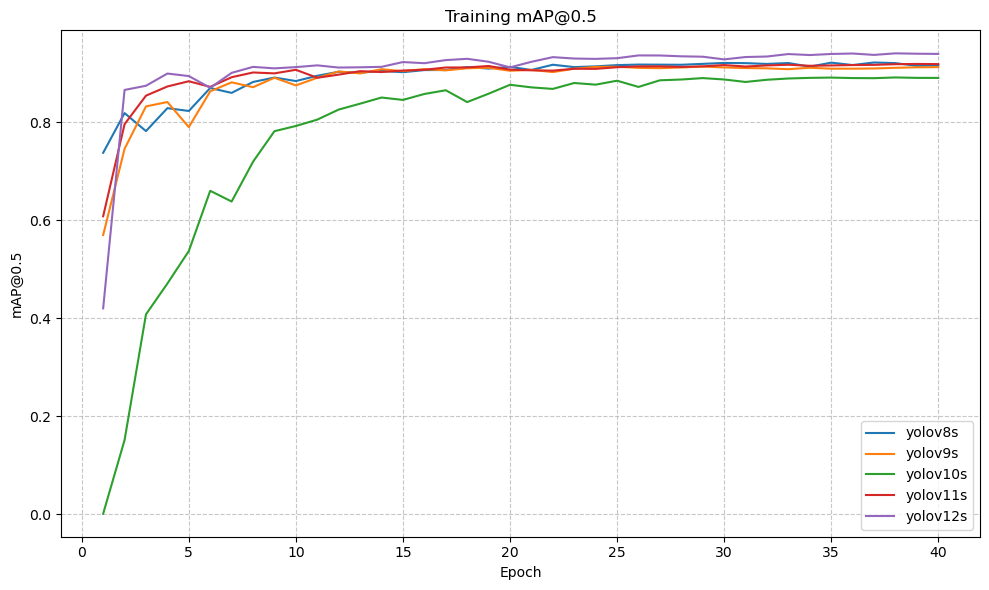

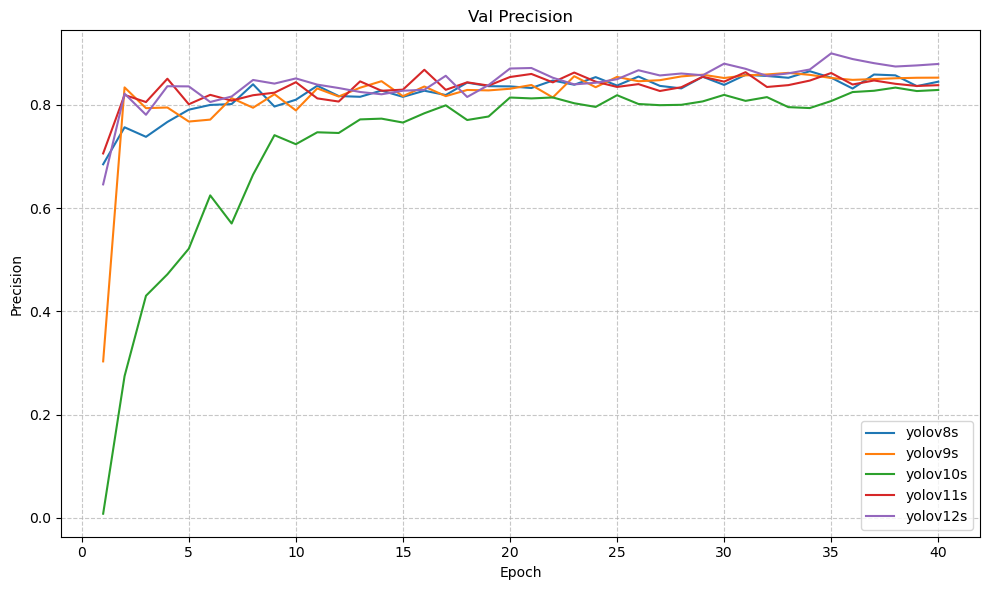

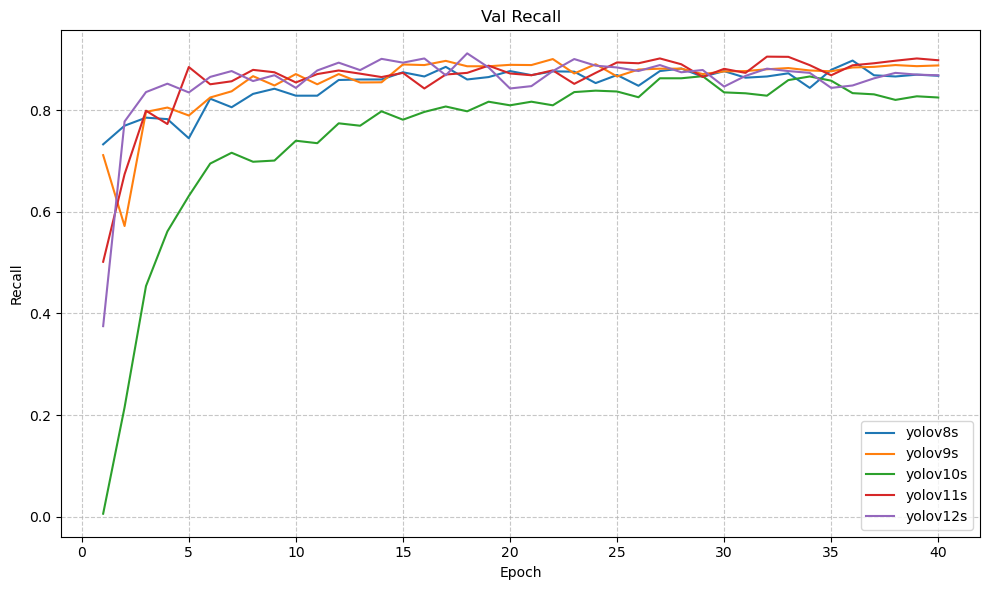

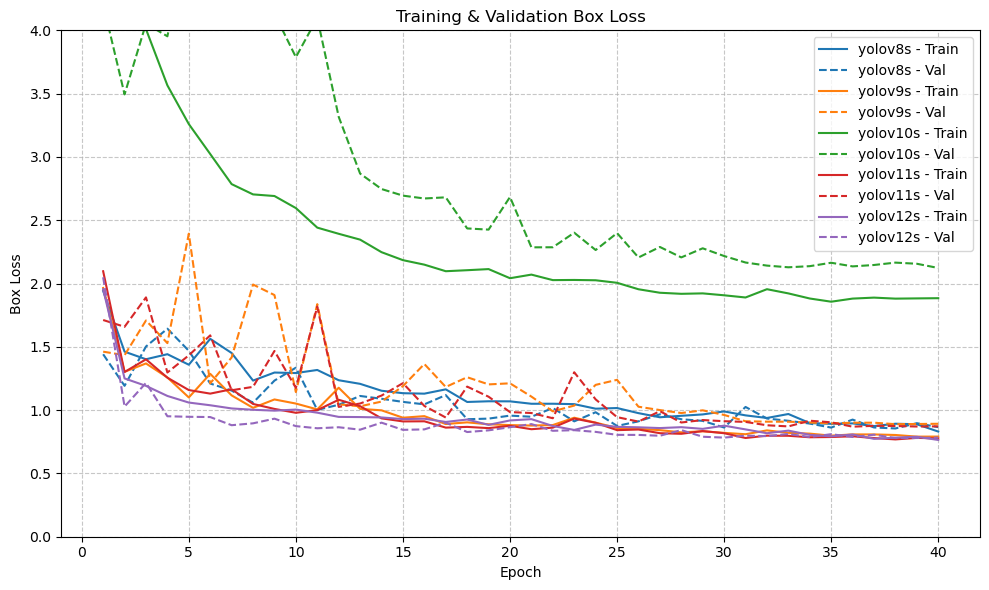

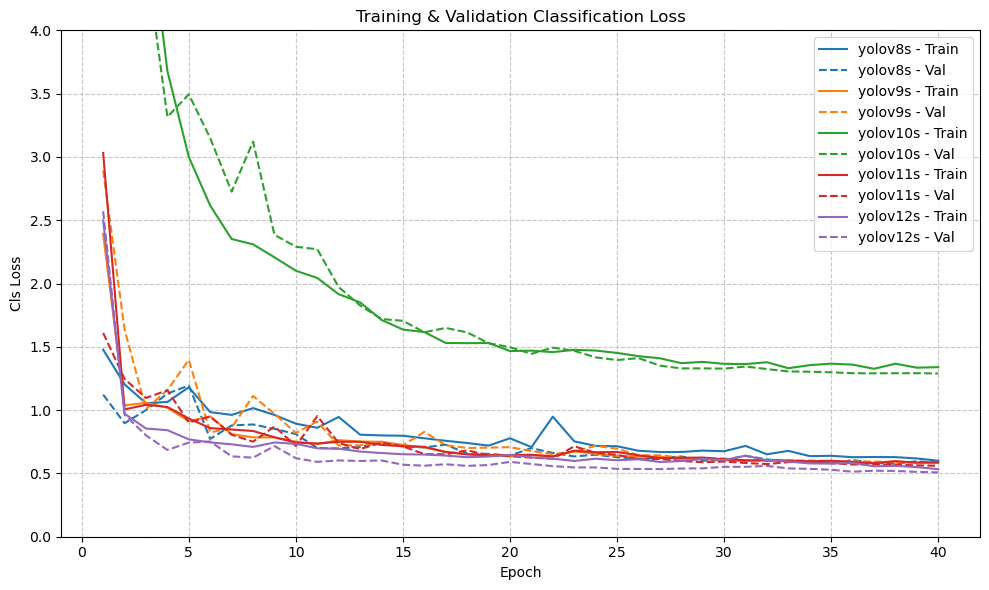

In [ ]:
plots_dir = 'yolo/yolo_plots'
dfs = plot_utils.load_experiment_results(config.results_csv_paths)

plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50-95', 'metrics/mAP50-95(B)', 'Training mAP@0.5:0.95', 'mAP@0.5:0.95')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50', 'metrics/mAP50(B)', 'Training mAP@0.5', 'mAP@0.5')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'precision', 'metrics/precision(B)', 'Val Precision', 'Precision')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'recall', 'metrics/recall(B)', 'Val Recall', 'Recall')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'box_loss', ['train/box_loss', 'val/box_loss'], 
                               'Training & Validation Box Loss', 'Box Loss', True, (0, 4))
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'cls_loss', ['train/cls_loss', 'val/cls_loss'], 
                               'Training & Validation Classification Loss', 'Cls Loss', True, (0, 4))

## **Evaluaciones de empresa**

In [6]:
tests = ["test", "test2", "test3"]
results = []
for test in tests:
    for name, path in config.final_model_path.items():
        model = YOLO(path)
        metrics = model.val(
            data="cells.yaml",
            split=test,
            imgsz=config.IMGSZ,
            batch=config.BATCH,
            name=f"eval_{name}_{test}"
        )
        results.append({
            "Modelo": name,
            "Test": test,
            "Precisión": metrics.box.mp,
            "Recall": metrics.box.mr,
            "mAP@0.5": metrics.box.map50,
            "mAP@0.5:0.95": metrics.box.map
        })

Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 15.18.8 MB/s, size: 79.2 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.78it/s]


                   all         88       1412      0.857      0.839      0.926      0.705
Speed: 1.2ms preprocess, 11.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\eval_yolov8s_test3
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 788.9317.7 MB/s, size: 81.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


                   all         88       1412       0.85      0.878      0.934      0.707
Speed: 1.5ms preprocess, 13.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\eval_yolov9s_test3
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 697.0299.8 MB/s, size: 102.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


                   all         88       1412      0.834      0.817      0.896      0.618
Speed: 1.9ms preprocess, 11.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\eval_yolov10s_test
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 545.7382.5 MB/s, size: 83.9 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


                   all         88       1412      0.847      0.867      0.932      0.717
Speed: 1.6ms preprocess, 10.6ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\eval_yolov11s_test3
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 808.1240.0 MB/s, size: 105.8 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


                   all         88       1412      0.863      0.849      0.937      0.741
Speed: 1.2ms preprocess, 15.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\eval_yolov12s_test12
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 11.64.1 MB/s, size: 99.5 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 299.26it/s]

val: New cache created: ..\03.Datasets\YOLO_Datasets\test2\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


                   all         10        144      0.924      0.938      0.969      0.553
Speed: 0.4ms preprocess, 14.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\eval_yolov8s_test22
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 760.2157.7 MB/s, size: 108.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


                   all         10        144      0.917      0.927      0.961      0.542
Speed: 0.5ms preprocess, 75.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\eval_yolov9s_test22
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 788.4165.6 MB/s, size: 109.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


                   all         10        144       0.94      0.875      0.951      0.562
Speed: 0.5ms preprocess, 14.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\eval_yolov10s_test2
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1015.4191.7 MB/s, size: 115.3 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


                   all         10        144      0.929      0.917      0.964      0.534
Speed: 0.6ms preprocess, 16.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs\detect\eval_yolov11s_test22
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 891.9200.1 MB/s, size: 113.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


                   all         10        144      0.965      0.917      0.975      0.556
Speed: 0.6ms preprocess, 19.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\eval_yolov12s_test22
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 27.97.5 MB/s, size: 248.3 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 301.86it/s]

val: New cache created: ..\03.Datasets\YOLO_Datasets\test3\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


                   all         59       1135      0.842      0.862      0.937        0.7
Speed: 2.6ms preprocess, 11.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\eval_yolov8s_test32
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1968.8359.8 MB/s, size: 284.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


                   all         59       1135      0.843       0.87      0.935      0.681
Speed: 2.9ms preprocess, 13.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\eval_yolov9s_test32
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1488.1325.1 MB/s, size: 248.0 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


                   all         59       1135      0.806      0.839      0.895      0.601
Speed: 2.6ms preprocess, 12.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\eval_yolov10s_test3
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1896.1204.7 MB/s, size: 269.1 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


                   all         59       1135      0.855      0.874      0.935      0.698
Speed: 2.5ms preprocess, 11.2ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\eval_yolov11s_test32
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1833.9103.2 MB/s, size: 271.6 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


                   all         59       1135      0.836      0.821      0.922      0.723
Speed: 1.6ms preprocess, 17.6ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs\detect\eval_yolov12s_test32


In [7]:
df = pd.DataFrame(results)
display(df)

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95
0,yolov8s,test,0.856835,0.839247,0.926338,0.705017
1,yolov9s,test,0.849800,0.878187,0.933841,0.706728
2,yolov10s,test,0.833663,0.817280,0.896401,0.617821
3,yolov11s,test,0.847019,0.866592,0.931684,0.716655
4,yolov12s,test,0.863138,0.848629,0.937264,0.740666
5,yolov8s,test2,0.923798,0.937500,0.968788,0.553424
6,yolov9s,test2,0.917499,0.926773,0.961256,0.541765
7,yolov10s,test2,0.940299,0.875013,0.950769,0.561551
8,yolov11s,test2,0.928950,0.916667,0.964048,0.534350
9,yolov12s,test2,0.964634,0.916667,0.974530,0.555905


In [ ]:
# === Ensemble: Concat+NMS y Weighted Boxes Fusion (WBF) y evaluación en test, test2, test3 ===
# Requiere: pip install ensemble-boxes (solo para WBF)
# %pip install ensemble-boxes

import os, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from ultralytics import YOLO

try:
    from ensemble_boxes import weighted_boxes_fusion
    HAS_WBF = True
except ImportError:
    HAS_WBF = False
    print("Instala ensemble-boxes para WBF: pip install ensemble-boxes")

# Modelos base seleccionados para el ensemble
ensemble_model_paths = {
    "yolov12s": config.final_model_path["yolov12s"],
    "yolov11s": config.final_model_path["yolov11s"],
    "yolov8s":  config.final_model_path["yolov8s"],
}

base_models = {k: YOLO(p) for k,p in ensemble_model_paths.items()}

# Pesos (puedes ajustarlos usando mAP@0.5:0.95 de validación)
model_weights = {
    "yolov12s": 1.0,
    "yolov11s": 0.7,
    "yolov8s":  0.7
}

# Utilidades
def load_yolo_labels(label_file):
    boxes = []
    if not os.path.exists(label_file):
        return np.zeros((0,5), dtype=float)
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, w, h = map(float, parts)
            boxes.append([cls, x, y, w, h])
    return np.array(boxes, dtype=float) if boxes else np.zeros((0,5), dtype=float)

def yolo_to_xyxy_norm(boxes):
    # boxes: (N,5) cls, cx, cy, w, h (normalizado)
    if boxes.size == 0:
        return boxes[:, :0]
    cx, cy, w, h = boxes[:,1], boxes[:,2], boxes[:,3], boxes[:,4]
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    return np.stack([x1,y1,x2,y2], axis=1)

def xyxy_to_yolo_norm(xyxy):
    # xyxy normalizado -> (cx,cy,w,h)
    if xyxy.size == 0:
        return xyxy[:, :0]
    x1,y1,x2,y2 = xyxy[:,0], xyxy[:,1], xyxy[:,2], xyxy[:,3]
    w = x2 - x1
    h = y2 - y1
    cx = x1 + w/2
    cy = y1 + h/2
    return np.stack([cx,cy,w,h], axis=1)

def iou_matrix(a, b):
    # a,b: (N,4) (M,4) en formato xyxy normalizado
    if a.size == 0 or b.size == 0:
        return np.zeros((len(a), len(b)), dtype=float)
    ious = np.zeros((len(a), len(b)), dtype=float)
    for i, box_a in enumerate(a):
        ax1, ay1, ax2, ay2 = box_a
        aarea = max(0, ax2-ax1) * max(0, ay2-ay1)
        for j, box_b in enumerate(b):
            bx1, by1, bx2, by2 = box_b
            barea = max(0, bx2-bx1) * max(0, by2-by1)
            ix1 = max(ax1, bx1)
            iy1 = max(ay1, by1)
            ix2 = min(ax2, bx2)
            iy2 = min(ay2, by2)
            iw = max(0, ix2-ix1)
            ih = max(0, iy2-iy1)
            inter = iw * ih
            union = aarea + barea - inter
            ious[i,j] = inter / union if union > 0 else 0.0
    return ious

def soft_nms(boxes, scores, iou_thr=0.9, sigma=0.9, score_thr=0.9):
    # boxes: (N,4), scores: (N,)
    boxes = boxes.copy()
    scores = scores.copy()
    N = boxes.shape[0]
    keep = []
    for i in range(N):
        maxscore = scores[i]
        maxpos = i

        # Get max score box
        for j in range(i+1, N):
            if scores[j] > maxscore:
                maxscore = scores[j]
                maxpos = j
        # Swap
        boxes[i], boxes[maxpos] = boxes[maxpos].copy(), boxes[i].copy()
        scores[i], scores[maxpos] = scores[maxpos], scores[i]

        boxA = boxes[i]
        for j in range(i+1, N):
            boxB = boxes[j]
            # IoU
            xx1 = max(boxA[0], boxB[0])
            yy1 = max(boxA[1], boxB[1])
            xx2 = min(boxA[2], boxB[2])
            yy2 = min(boxA[3], boxB[3])
            w = max(0.0, xx2 - xx1)
            h = max(0.0, yy2 - yy1)
            inter = w * h
            areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
            areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
            iou = inter / (areaA + areaB - inter) if (areaA + areaB - inter) > 0 else 0.0

            # Soft-NMS
            if iou > iou_thr:
                scores[j] *= np.exp(- (iou ** 2) / sigma)
        if scores[i] > score_thr:
            keep.append(i)
    return np.array(keep)

def nms_concat(pred_lists, iou_thr=0.9, conf_thr=0.9, use_soft_nms=True):
    # pred_lists: lista de dicts con keys: boxes (xyxy norm), conf, cls
    if not pred_lists:
        return np.zeros((0,6))
    all_boxes = []
    for p in pred_lists:
        boxes = p["boxes"]
        scores = p["conf"]
        cls = p["cls"]
        arr = np.concatenate([boxes, scores[:,None], cls[:,None]], axis=1)
        all_boxes.append(arr)
    dets = np.concatenate(all_boxes, axis=0)
    dets = dets[dets[:,4] >= conf_thr]
    if dets.shape[0] == 0:
        return dets
    keep_final = []
    for c in np.unique(dets[:,5]):
        dc = dets[dets[:,5]==c]
        if use_soft_nms:
            idx = soft_nms(dc[:,:4], dc[:,4], iou_thr=iou_thr, sigma=0.5, score_thr=conf_thr)
        else:
            tboxes = torch.tensor(dc[:,:4])
            tscores = torch.tensor(dc[:,4])
            idx = torch.ops.torchvision.nms(tboxes, tscores, iou_thr).numpy()
        keep_final.append(dc[idx])
    return np.concatenate(keep_final, axis=0) if keep_final else np.zeros((0,6))

def predict_single_model(model, image_path, imgsz):
    r = model.predict(image_path, imgsz=imgsz, conf=0.001, verbose=False)[0]
    h, w = r.orig_shape
    if r.boxes.shape[0] == 0:
        return {"boxes": np.zeros((0,4)), "conf": np.zeros((0,)), "cls": np.zeros((0,))}
    xyxy = r.boxes.xyxy.cpu().numpy()
    conf = r.boxes.conf.cpu().numpy()
    cls = r.boxes.cls.cpu().numpy()
    # Normalizar
    xyxy_norm = xyxy.copy()
    xyxy_norm[:,[0,2]] /= w
    xyxy_norm[:,[1,3]] /= h
    return {"boxes": xyxy_norm, "conf": conf, "cls": cls}

def ensemble_concat_nms(image_path, imgsz=704, iou_thr=0.90, conf_thr=0.9):
    plist = [predict_single_model(m, image_path, imgsz) for m in base_models.values()]
    dets = nms_concat(plist, iou_thr=iou_thr, conf_thr=conf_thr)
    return dets  # (N,6) xyxy + conf + cls (normalizado)

def ensemble_wbf(image_path, imgsz=704, iou_thr=0.9, skip_box_thr=0.5):
    if not HAS_WBF:
        return np.zeros((0,6))
    boxes_list, scores_list, labels_list, weights = [], [], [], []
    shapes = None
    for name, m in base_models.items():
        r = predict_single_model(m, image_path, imgsz)
        boxes_list.append(r["boxes"].tolist())
        scores_list.append(r["conf"].tolist())
        labels_list.append(r["cls"].astype(int).tolist())
        weights.append(model_weights[name])
    if sum(len(b) for b in boxes_list) == 0:
        return np.zeros((0,6))
    fused_boxes, fused_scores, fused_labels = weighted_boxes_fusion(
        boxes_list, scores_list, labels_list,
        weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr
    )
    fused_boxes = np.array(fused_boxes)
    fused_scores = np.array(fused_scores)
    fused_labels = np.array(fused_labels)
    return np.concatenate([fused_boxes, fused_scores[:,None], fused_labels[:,None]], axis=1)

# Métricas (AP@0.5 y AP@[0.5:0.95], precisión y recall global)
def compute_metrics(preds_all, gts_all, iou_thresholds=None):
    # preds_all & gts_all: listas por imagen
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)
    # Para precisión/recall global a IoU=0.5 (primera)
    iou_main = iou_thresholds[0]
    tp_main = 0
    fp_main = 0
    fn_main = 0

    # AP por IoU
    APs = []
    for t in iou_thresholds:
        scores = []
        matches = []
        total_gts = 0
        # Recolectar predicciones (1 clase)
        all_pred_entries = []
        for preds, gts in zip(preds_all, gts_all):
            # gts: (M,4) xyxy norm
            total_gts += gts.shape[0]
            if preds.shape[0] == 0:
                continue
            # Ordenar por score
            order = np.argsort(-preds[:,4])
            p = preds[order]
            matched = np.zeros(gts.shape[0], dtype=bool)
            for row in p:
                box_p = row[:4][None,:]
                ious = iou_matrix(box_p, gts)
                best_i = np.argmax(ious[0]) if gts.shape[0] else -1
                best_iou = ious[0,best_i] if gts.shape[0] else 0
                is_tp = best_iou >= t and (best_i >=0) and (not matched[best_i])
                if is_tp:
                    matched[best_i] = True
                all_pred_entries.append((row[4], 1 if is_tp else 0))
            # fin imagen
        if total_gts == 0:
            APs.append(0.0)
            continue
        if not all_pred_entries:
            APs.append(0.0)
            continue
        all_pred_entries.sort(key=lambda x: -x[0])
        cum_tp = 0
        cum_fp = 0
        precisions = []
        recalls = []
        for sc, is_tp in all_pred_entries:
            if is_tp:
                cum_tp += 1
            else:
                cum_fp += 1
            precisions.append(cum_tp / (cum_tp + cum_fp))
            recalls.append(cum_tp / total_gts)
        # AP (interp 11 pts estilo voc o integración)
        # Usamos integración trapezoidal sobre recall ordenado
        precisions = np.array(precisions)
        recalls = np.array(recalls)
        # Asegurar monotonicidad descendente
        for i in range(len(precisions)-2, -1, -1):
            precisions[i] = max(precisions[i], precisions[i+1])
        # Puntos únicos en recall
        unique_recalls, idx = np.unique(recalls, return_index=True)
        ap = np.trapz(precisions[idx], unique_recalls)
        APs.append(ap)

        if math.isclose(t, iou_main):
            # Compute global precision/recall at main IoU (usar mismos matches)
            # Repetimos conteo
            total_gts_main = 0
            tp_m = 0
            fp_m = 0
            for preds, gts in zip(preds_all, gts_all):
                total_gts_main += gts.shape[0]
                if preds.shape[0] == 0:
                    continue
                order = np.argsort(-preds[:,4])
                p = preds[order]
                matched = np.zeros(gts.shape[0], dtype=bool)
                for row in p:
                    box_p = row[:4][None,:]
                    ious = iou_matrix(box_p, gts)
                    best_i = np.argmax(ious[0]) if gts.shape[0] else -1
                    best_iou = ious[0,best_i] if gts.shape[0] else 0
                    if best_iou >= iou_main and best_i >=0 and (not matched[best_i]):
                        matched[best_i] = True
                        tp_m += 1
                    else:
                        fp_m += 1
            fn_m = total_gts_main - tp_m
            tp_main, fp_main, fn_main = tp_m, fp_m, fn_m

    mp = tp_main / (tp_main + fp_main) if (tp_main + fp_main) > 0 else 0.0
    mr = tp_main / (tp_main + fn_main) if (tp_main + fn_main) > 0 else 0.0
    map50 = APs[0] if len(APs) > 0 else 0.0
    map5095 = float(np.mean(APs)) if APs else 0.0
    return {
        "mp": mp,
        "mr": mr,
        "map50": map50,
        "map": map5095
    }

def get_split_image_label_dirs(split_name):
    base = Path("..") / "03.Datasets" / "YOLO_Datasets"
    images = base / split_name / "images"
    labels = base / split_name / "labels"
    return images, labels

def evaluate_ensemble(split, method="concat_nms", imgsz=config.IMGSZ):
    img_dir, label_dir = get_split_image_label_dirs(split)
    image_paths = [p for p in img_dir.iterdir() if p.suffix.lower() in [".jpg", ".png", ".jpeg"]]
    preds_all = []
    gts_all = []
    for img_path in image_paths:
        # Ground truth
        gt_label = (label_dir / (img_path.stem + ".txt"))
        gts_raw = load_yolo_labels(str(gt_label))  # cls, cx, cy, w, h
        gts_xyxy = yolo_to_xyxy_norm(gts_raw) if gts_raw.size else np.zeros((0,4))
        gts_all.append(gts_xyxy)

        if method == "concat_nms":
            dets = ensemble_concat_nms(str(img_path), imgsz=imgsz, iou_thr=0.60, conf_thr=0.2)
        elif method == "wbf":
            dets = ensemble_wbf(str(img_path), imgsz=imgsz, iou_thr=0.70, skip_box_thr=0.3)
        else:
            dets = np.zeros((0,6))

        # dets: (N,6) xyxy + conf + cls
        preds_all.append(dets if dets.size else np.zeros((0,6)))
    metrics = compute_metrics(preds_all, gts_all)
    return metrics

test_splits = ["test","test2","test3"]
ensemble_results = []
for split in test_splits:
    # m1 = evaluate_ensemble(split, method="concat_nms")
    # ensemble_results.append({
    #     "Modelo": "ensemble_concat_nms",
    #     "Test": split,
    #     "Precisión": m1["mp"],
    #     "Recall": m1["mr"],
    #     "mAP@0.5": m1["map50"],
    #     "mAP@0.5:0.95": m1["map"]
    # })
    m2 = evaluate_ensemble(split, method="wbf")
    ensemble_results.append({
        "Modelo": "ensemble_wbf",
        "Test": split,
        "Precisión": m2["mp"],
        "Recall": m2["mr"],
        "mAP@0.5": m2["map50"],
        "mAP@0.5:0.95": m2["map"]
    })

df_ensemble = pd.DataFrame(ensemble_results)
display(df_ensemble)

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95
0,ensemble_wbf,test,0.831238,0.889518,0.867120,0.688601
1,ensemble_wbf,test2,0.889610,0.951389,0.938503,0.491512
2,ensemble_wbf,test3,0.821885,0.906608,0.884963,0.703167


Probar a entrenar Yolo con capas de atención y mucho más personalizados algunos modelos.

| Imagen            | Test      | yolov8s 0.5 | yolov8s 0.7 | yolov9s 0.5 | yolov9s 0.7 | yolov10n 0.5 | yolov10n 0.7 | yolov11s 0.5 | yolov11s 0.7 | yolov12s 0.5 | yolov12s 0.7 | Num Artefactos | Num Etiquetados |
|-------------------|:---------:|:-----------:|:-----------:|:-----------:|:-----------:|:------------:|:------------:|:------------:|:------------:|:------------:|:------------:|:--------------:|:---------------:|
| 59 imagen         |           |             |             |     ❌      |     ✅      |     ✅      |     ✅      |     ✅      |     ✅      |     ✅      |     ✅      |      3       |                 |
| 61 imagen         |           |             |             |     ❌      |     ✅      |     ❌      |     ✅      |     ❌      |     ✅      |     ✅      |     ✅      |      3       |                 |
| 219 imagen        |           |             |             |     ❌      |     ❌      |     ❌      |     ❌      |     ❌      |     ✅      |     ✅      |     ✅      |              |                 |
| 369 imagen        |           |             |             |     ❌      |     ❌      |     ❌      |     ✅      |     ✅      |     ✅      |     ✅      |     ✅      |              |                 |
| already tested-00 |           |             |             |             |             |             |             |             |             |             |             |              |                 |
| already tested-15 |           |             |             |             |             |             |             |             |             |             |             |              |                 |
| already tested-16 |           |             |             |             |             |             |             |             |             |             |             |              |                 |
| already tested-17 |           |             |             |             |             |             |             |             |             |             |             |              |                 |
| already tested-22 |           |             |             |             |             |             |             |             |             |             |             |              |                 |

## **Conclusión**

## **Comentarios reunión semanal**

Para el power point usar el mes gratis de copilot, así lo redacto mejor y más rápido la presentación

"no es posible distinguir entre leucocitos y células germinales inmaduras con un alto grado de certeza (2)" https://pmc.ncbi.nlm.nih.gov/articles/PMC8915675/

Quiero probar este modelo: https://github.com/Peterande/D-FINE?tab=readme-ov-file

comentar en la memoria el uso de linters como ruff